# Notebook for analysing all VR trials of one experimental group; 2-object forest
## Assumes use of FlyOver version 9.7 or higher (closed-loop optogenetic stimulation possible)
## Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [236]:
__author__ = 'Hannah Haberkern, hjmhaberkern@gmail.com'

import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk, getcwd
from os.path import isfile, sep, exists
from sys import path, exit
from glob import glob
from operator import itemgetter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec, rcParams
import seaborn as sns

from scipy import stats as sts

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from flyVR.flyVRoptogenetics.flyVRoptogenetics_oneTrialBasicAnalysis import singleTwoObjVROptogenTrialAnalysis

from plottingUtilities.basicPlotting import myAxisTheme,_myAccentList
from plottingUtilities.objectInteractionPlots import plotWalkingVelocityDistr
from plottingUtilities.plotsWithDataframe import plotVeloHeadingDistribution_flyVR_df,\
            plotVeloHeadingDistribution2_flyVR_df,oneDimResidencyWithVar_2LM_df
from plottingUtilities.objectPreferencePlots import countvisits, diffCorrPlot, prettyBoxPlot, simpleBoxPlot,\
            landmarksInSquareTile


# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr64f-Double-Gal4_x_10xChrimsonR/female/'
root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [237]:
# Uncomment, if you want to select a specific subset of flies (e.g. good learners..)
my_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]#[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17]#
expDirs = itemgetter(*my_indices)(expDirs)

selectionTag = '_min5Visits'#_min3visitsEachPre'  # chose small string, to specify dataset (e.g. top5 flies)

In [238]:
expDirs=expDirs[:]
print(expDirs)

('f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21')


In [239]:
%matplotlib inline
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

### Compose mutli-fly data into dataframe

In [240]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [241]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [242]:
dataDir.split(sep)

['',
 'Volumes',
 'jayaramanlab',
 'Hannah',
 'Projects',
 'FlyVR',
 '1_Experiments',
 'twoObjOpto',
 'Gr64f-Double-Gal4_x_10xChrimsonR',
 'female',
 'cone_20min_15mm_AC',
 'rawData',
 '']

In [243]:
genotype = dataDir.split(sep)[-6] #5
starvation = dataDir.split(sep)[-3] #+ '_'+dataDir.split(sep)[-5]
print(genotype)
print(starvation)

twoObjOpto
cone_20min_15mm_AC


In [244]:
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','starvation','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)
 
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:
        
        flyID = fileToAnalyse.split('_')[6]
        stimT = fileToAnalyse.split('_')[-4]
        
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        if rerunbasicanalysis == 'y':
            returnVal = singleTwoObjVROptogenTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'train' in fileToAnalyse:
            trialtype = 'train'
            rZones = 'on'
        elif 'pre' in fileToAnalyse:
            trialtype = 'pre'
            rZones = 'off'
        else:
            trialtype = 'post'
            rZones = 'off'
        
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'reinforcement', rZones)
        FODatLoad_df.insert(4, 'starvation', starvation)
        FODatLoad_df.insert(5, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        
        # TODO: Add selection criteria, e.g. to only include trials from flies that were 
        # walking >40% of time and did not have a strong turn bias.
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr64f-Double-Gal4_x_10xChrimsonR/female/cone_20min_15mm_AC/rawData/f01/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_6-8d_24h_f01_RWf_200ms_post_out_180822182518.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_6-8d_24h_f01_RWf_200ms_pre_out_180822175324.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_6-8d_24h_f01_RWf_200ms_train_out_180822180453.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr64f-Double-Gal4_x_10xChrimsonR/female/cone_20min_15mm_AC/rawData/f02/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_6-8d_24h_f02_RWf_200ms_post_out_180822194930.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_6-8d_24h_f02_RWf_200ms_

Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr64f-Double-Gal4_x_10xChrimsonR/female/cone_20min_15mm_AC/rawData/f16/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_6-8d_24h_f16_RWf_200ms_post_out_180826224457.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_6-8d_24h_f16_RWf_200ms_pre_out_180826221409.txt', 'twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_6-8d_24h_f16_RWf_200ms_train_out_180826222438.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr64f-Double-Gal4_x_10xChrimsonR/female/cone_20min_15mm_AC/rawData/f17/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1R_08cm3cmCyliz2_6cmGrid_6-8d_24h_f17_RWf_200ms_post_out_180830153329.txt', 'twoObjectForest_1cm4cmC

In [245]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df.head()

flyID trial trialtype reinforcement          starvation  moving  \
0   f01   1.0      post           off  cone_20min_15mm_AC     1.0   
1   f01   1.0      post           off  cone_20min_15mm_AC     1.0   
2   f01   1.0      post           off  cone_20min_15mm_AC     1.0   
3   f01   1.0      post           off  cone_20min_15mm_AC     1.0   
4   f01   1.0      post           off  cone_20min_15mm_AC     1.0   

   headingAngle   rotVelo      time  transVelo       xPos  xPosInMiniarena  \
0     -0.000004 -4.472665  0.000000   5.371831  60.622000        60.622000   
1     -0.223657 -5.512900  0.050004   3.013360  60.569901        60.569901   
2     -0.499326 -2.806020  0.100009   4.301429  60.712500        60.712500   
3     -0.639640 -1.562674  0.150013   8.661738  60.890600        60.890600   
4     -0.717781 -1.456243  0.200018   5.801073  61.220545        61.220545   

        yPos  yPosInMiniarena  rEvents  
0  35.000000        35.000000      0.0  
1  35.263515        35.263515      0.0  
2  35.312200        35.312200      0.0  
3  35.191600        35.191600      0.0  
4  34.911004        34.911004      0.0

In [246]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_EV = keylistLong.index('rEvents')

flyIDallarray = np.asarray(FOAllFlies_df['flyID'].values).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [247]:
# Two object reinforcement test
rZoneState = ['off','on','off']
trialName = ['pre','train','post']
gridSize = 60.0

fps = 20.0 # after downsampling

coneColor = 'mediumseagreen'
cyliColor = 'mediumorchid'
LMcols = [coneColor,cyliColor]

objtypeNames = ['Cone','Cylinder']
numObj = len(objtypeNames)

In [248]:
visitRad = 15
# Use 15 mm as standard visit radius with two-landmark forest world, where
# LM are at least 60 mm separated.

coneCoords = [[gridSize/2, gridSize/2],
              [3*gridSize/2, -gridSize/2]]
cyliCoords = [[gridSize/2, -gridSize/2],
              [3*gridSize/2, gridSize/2]]

LMcoords = [coneCoords, cyliCoords]

### Compute visit counts

In [249]:
visitFreq = np.nan*np.ones((numObj, len(flyIDs), len(trialName)))
visitCount = np.nan*np.ones((numObj, len(flyIDs), len(trialName)))
visitLength = np.zeros((numObj, len(flyIDs), len(trialName)))

for fly in range(len(flyIDs)):
    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

        # compute distance to closest landmark for each type
        dist2closest = np.nan*np.ones( (numObj, len(xtrial)) )
        
        for obj in range(numObj):
            dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                           np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
            
            entries,exits,visitT,entryTime,exitTime = countvisits(dist2closest[obj,:],time,visitRad)
        
            visitFreq[obj,fly,trial] = np.sum(entries)/(time[-1]/60.0)
            visitCount[obj,fly,trial] = np.sum(entries)
            visitLength[obj,fly,trial] = np.sum(visitT)

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in minimum


### Selection of flies for analysis based on landmark visits

In [169]:
# minimum amount of visits to ANY landmark in any trial to be considered in ananlysis
minVisit = 5

notEnoughVisits = np.where(np.sum((visitCount[0][:,:] + visitCount[1][:,:])> minVisit, axis=1)<3)[0]
keepflies = list(np.where(np.sum((visitCount[0][:,:] + visitCount[1][:,:])> minVisit, axis=1)>=3)[0])

# median # visits during training in group of flies that performed minimum amount of visits:
keepMedian = np.median(visitCount[0][keepflies,1])

# split flies to keep along the median
aboveMedian = list(set(np.where(visitCount[0][:,1]>keepMedian)[0]).intersection(set(keepflies)))
belowMedian = list(set(np.where(visitCount[0][:,1]<=keepMedian)[0]).intersection(set(keepflies)))

print('Out of {} measured flies, {} made less than {} landmark visits in at least one of the three trials ({}%).\n').format(numFlies,
     len(notEnoughVisits), minVisit, 100*len(notEnoughVisits)/numFlies)
print('Flies that made enough visits:')
print(keepflies)
print('\n')
print('The remaining {} flies can be split along the median of {} visits:').format(len(keepflies), keepMedian)
print('Above median:')
print(aboveMedian)
print('Below or equal to median:')
print(belowMedian)

Out of 17 measured flies, 0 made less than 5 landmark visits in at least one of the three trials (0%).

Flies that made enough visits:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


The remaining 17 flies can be split along the median of 23.0 visits:
Above median:
[0, 1, 2, 3, 6, 7, 8, 11]
Below or equal to median:
[4, 5, 9, 10, 12, 13, 14, 15, 16]


In [170]:
# minimum amount of visits to EACH landmark in the PRE-trial to be considered in ananlysis
minVisitLM = 3

notEnoughVisits = np.where(((visitCount[0][:,0] > minVisitLM).astype('int') + 
                            (visitCount[1][:,0] > minVisitLM).astype('int')) <2)[0]
keepflies = list(np.where(((visitCount[0][:,0] > minVisitLM).astype('int') + 
                           (visitCount[1][:,0] > minVisitLM).astype('int')) >=2)[0])

print('Flies that made enough visits:')
print(keepflies)
print('n = ' + str(len(keepflies)))

Flies that made enough visits:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
n = 17


In [171]:
# Select flies to create 
visitLength[0][np.isnan(visitLength[0])] = 0

vistiLength_slct = visitLength[0][visitLength[0][:,0] >= np.median(visitLength[0][:,0]),0]
print(np.median(vistiLength_slct))

aboveMedianLength = list(set(np.where(visitLength[0][:,0] >= np.median(visitLength[0][:,0]))[0]))
print(aboveMedianLength)

60.6055615235
[1, 3, 5, 6, 9, 10, 12, 13, 16]


### Trajectory plots of all trials

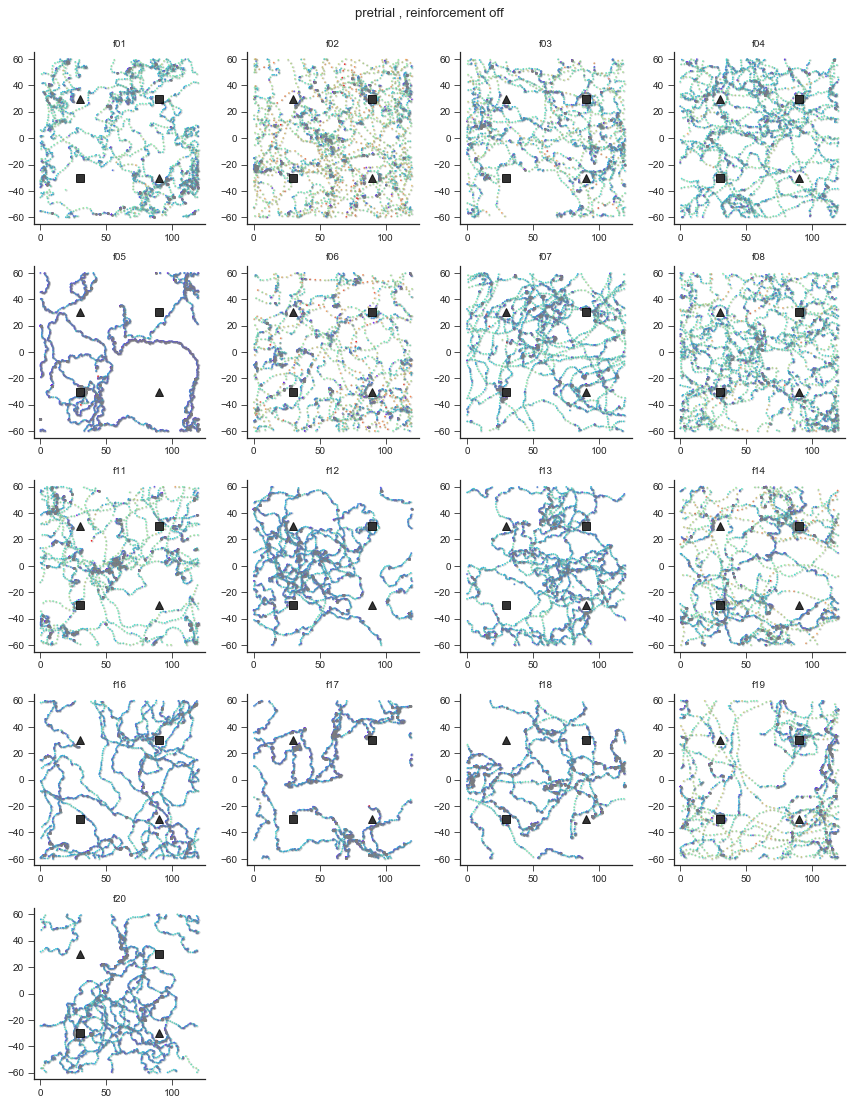

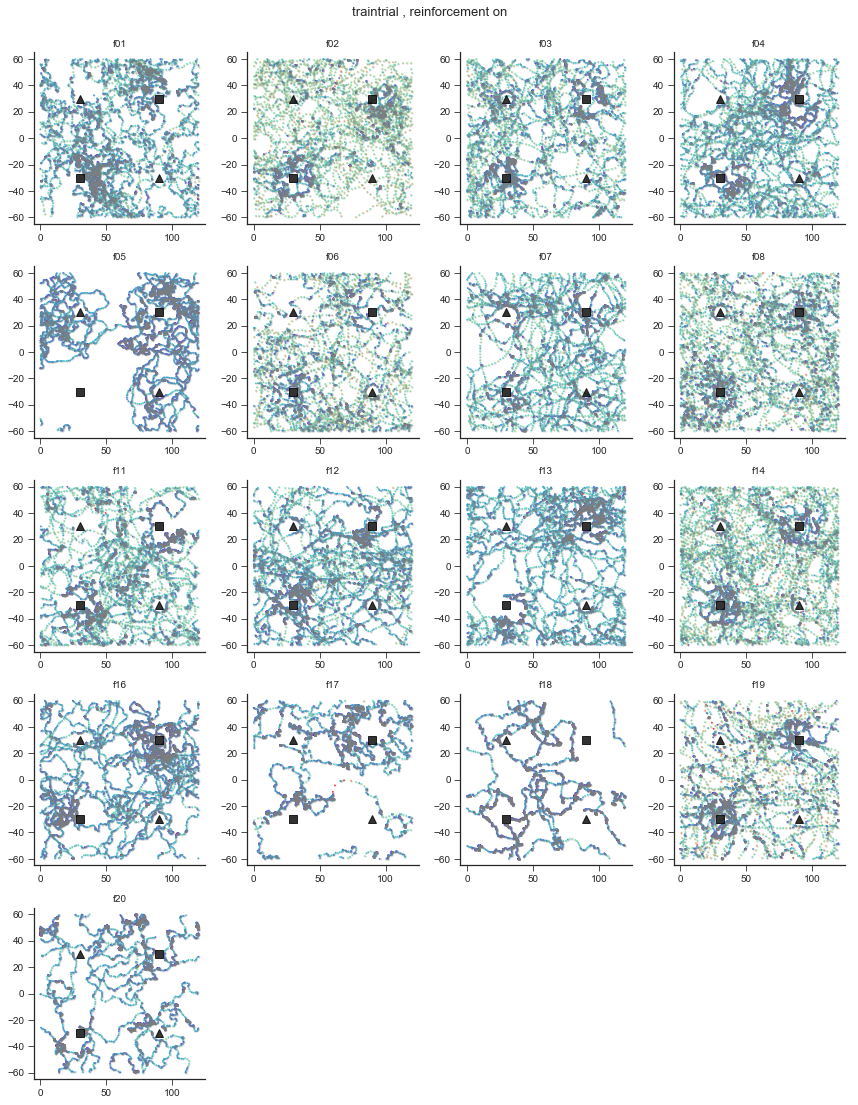

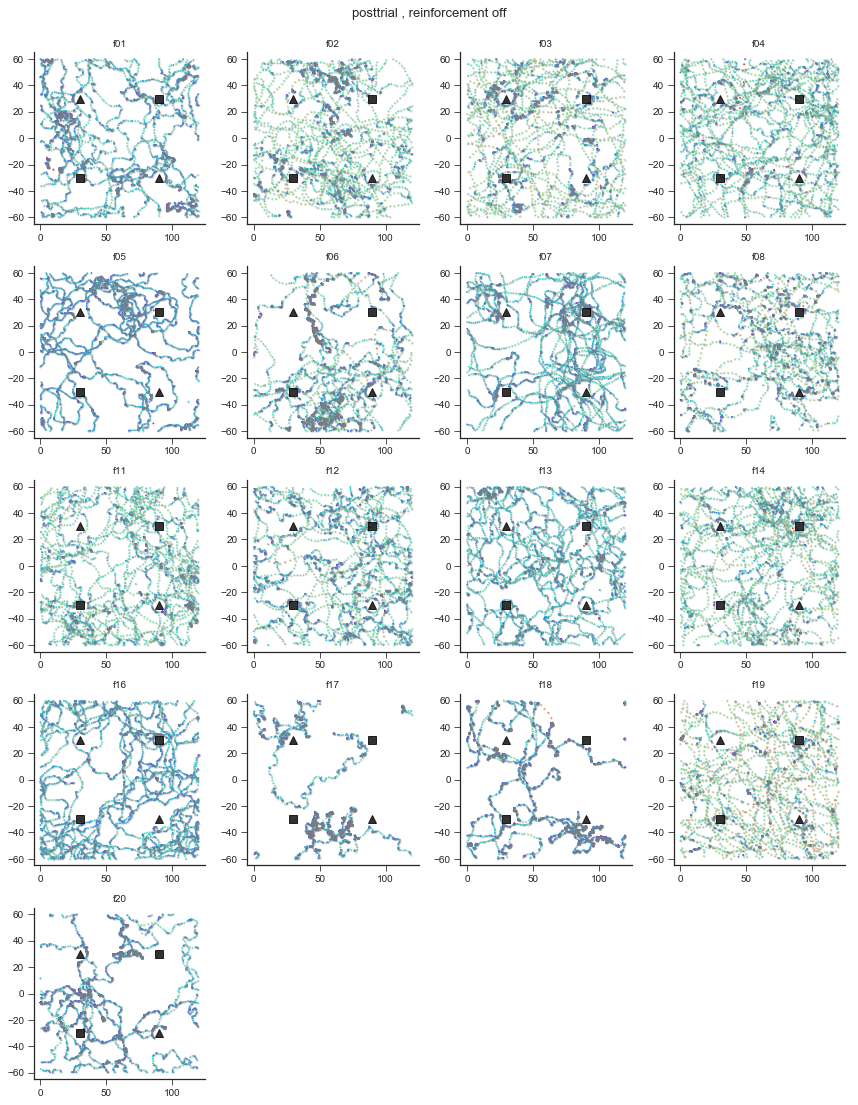

In [172]:
nrows = np.ceil(numFlies/4.0)
for ttind,trialtype in enumerate(trialName):
    multiflyTracePlot = plt.figure(figsize=(12,3*nrows))
    figtitle = multiflyTracePlot.suptitle(trialtype + 'trial , reinforcement ' + rZoneState[ttind] ,fontsize=13,y=1.02)
    for fly in range(numFlies):
        multiflyTracePlot_sbplt = multiflyTracePlot.add_subplot(nrows,4,fly+1)
       
        querystring = '(trialtype=="' + trialtype + '") & (flyID =="' + flyIDs[fly] +  '")'

        perFlyX = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        perFlyY = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        perFlyvT = FOAllFlies_df.query(querystring)['transVelo'].values.squeeze()
        
        selectPts = range(0,len(perFlyX),3)
        #color = scalarMap.to_rgba(timecolor), alpha = 0.1)
        multiflyTracePlot_sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        multiflyTracePlot_sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)
        
        landmarksInSquareTile(multiflyTracePlot_sbplt, LMcoords, ['k','k'])
        
        myAxisTheme(multiflyTracePlot_sbplt)
        multiflyTracePlot_sbplt.set_title(flyIDs[fly],fontsize=10)
        multiflyTracePlot_sbplt.set_aspect('equal')
        multiflyTracePlot_sbplt.set_xlim(-5, gridSize*2 + 5)
        multiflyTracePlot_sbplt.set_ylim(-5-gridSize, gridSize + 5)
        
    multiflyTracePlot.tight_layout()
    
    multiflyTracePlot.savefig(analysisDir +'tracePlotMA/'+ genotype +'_'+flyIDs[0][0] +'_'+ trialtype +'_trial'+ rZoneState[ttind]
                              +'_traceVeloColored_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf', 
                              bbox_extra_artists=(figtitle,), bbox_inches='tight')

## Velocity distributions

In [173]:
histRangeVT = (vTransTH, 30)
histRangeVR = (-5,5)
numBins = 31

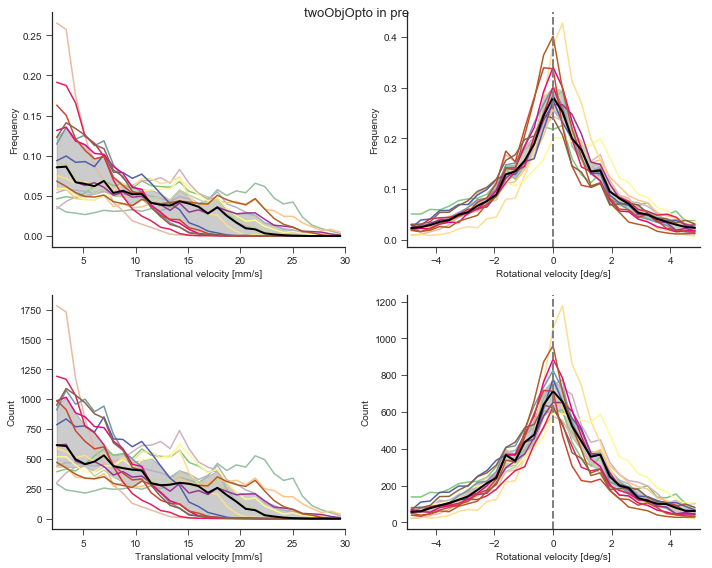

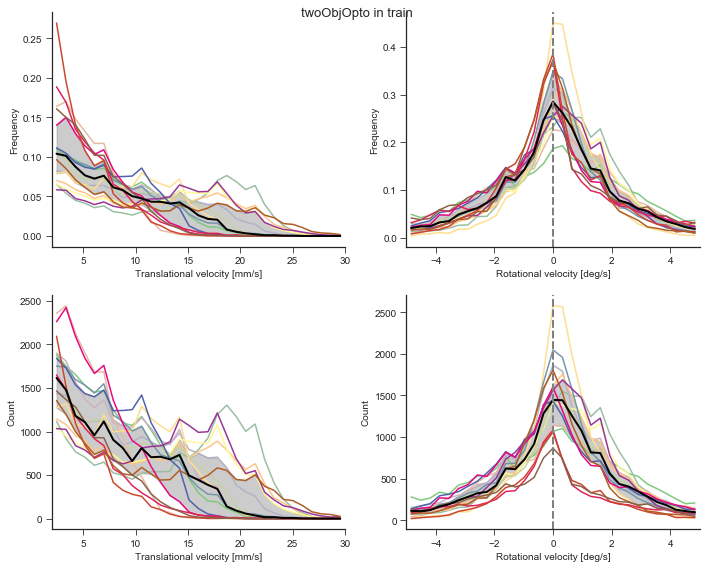

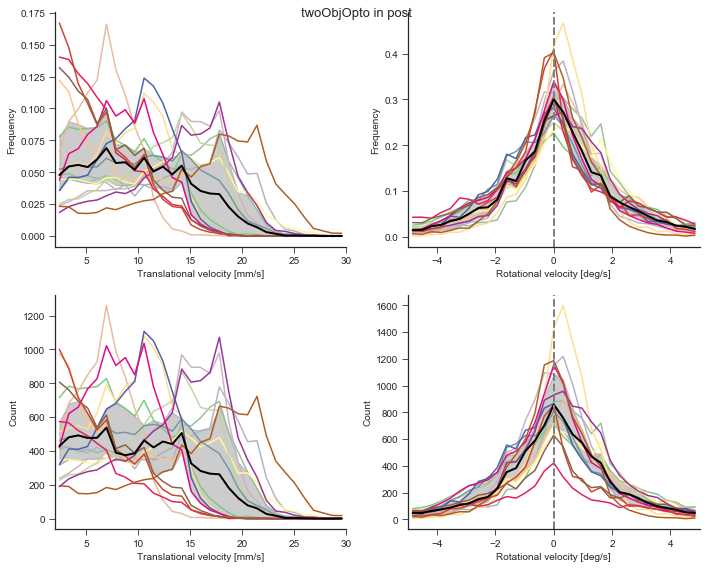

In [174]:
for tind, tname in enumerate(trialName):
    scene_df = FOAllFlies_df.query('trialtype == "' + tname + '"')
    titleString = genotype+' in '+ tname
    
    walkingFig = plotWalkingVelocityDistr(scene_df, flyIDs, keyind_mov, keyind_vT, keyind_vR, flyCMap,
                                 histRangeVT, histRangeVR,numBins, numFlies)
    walkingFig.suptitle(titleString, fontsize=13)
    walkingFig.tight_layout()

    walkingFig.savefig(analysisDir + sep + 'velocityTraces' + sep + genotype + '_walingVelocities_'+tname+\
                       '_medianIQR_n'+str(numFlies)+selectionTag+'.pdf', format = 'pdf')

### Check if some flies had a strong bias in their rotational velocity

In [175]:
rotbias = np.nan*np.ones((numFlies, len(trialName)))
rotamount = np.nan*np.ones((numFlies, len(trialName)))

for fly in range(numFlies):
    for i, trial in enumerate(trialName):
        querystring = '(trialtype=="' + trial + '") & (flyID =="' + flyIDs[fly] +  '") & (moving > 0)'
        perFlyvR = FOAllFlies_df.query(querystring)['rotVelo'].values.squeeze()

        if len(perFlyvR) == 0: continue
        
        rotbias[fly,i] = abs(sum(perFlyvR<0) - sum(perFlyvR>0)) / float(len(perFlyvR))
        rotamount[fly,i] = np.mean(abs(perFlyvR))

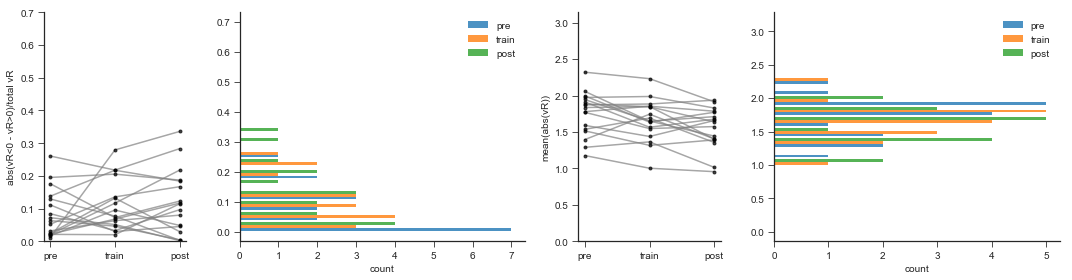

In [176]:
rotBiasfig, axs = plt.subplots(1,4,figsize=(15,4), gridspec_kw={'width_ratios':[1,2,1,2]})

axs[0].plot(rotbias.T, alpha=0.7, color='grey')
axs[0].plot(rotbias.T, '.', alpha=0.7,color='k')
axs[0].set_xticks([0,1,2])
axs[0].set_xticklabels(trialName)
axs[0].set_ylim(0, 0.7)
axs[0].set_ylabel('abs(vR<0 - vR>0)/total vR')

axs[1].hist(rotbias[:,:], range=(0,0.7), bins=20, cumulative=False, histtype='bar',
            align='mid',  orientation='horizontal', alpha=0.8)
axs[1].legend(trialName)
axs[1].set_xlabel('count')

axs[2].plot(rotamount.T, alpha=0.7,color='grey')
axs[2].plot(rotamount.T, '.', alpha=0.7,color='k')
axs[2].set_xticks([0,1,2])
axs[2].set_xticklabels(trialName)
axs[2].set_ylim(0, np.pi)
axs[2].set_ylabel('mean(abs(vR))')

axs[3].hist(rotamount[:,:], range=(0,np.pi), bins=20, cumulative=False, histtype='bar',
            align='mid', orientation='horizontal',  alpha=0.8)
axs[3].legend(trialName)
axs[3].set_xlabel('count')

for ax in axs:
    myAxisTheme(ax)
rotBiasfig.tight_layout()

rotBiasfig.savefig(analysisDir + sep + 'velocityTraces' + sep + genotype + '_walingVelocities_rotationalBias_n'+
                 str(numFlies)+selectionTag+'.pdf', format = 'pdf')

In [177]:
# Which flies had an excessive rotational bias throughout the experiment?
maxRotBias = 0.25

highRotBias = np.where(np.sum(rotbias>maxRotBias, axis=1)==3)[0]

print('Out of {} measured flies, {} had a rotational bias above {} in all three trials.\n').format(numFlies,
     len(highRotBias), maxRotBias)
print ('Those flies were: {}'.format([flyIDs[i] for i in highRotBias]))
print ('With indices {}'.format( highRotBias))

Out of 17 measured flies, 0 had a rotational bias above 0.25 in all three trials.

Those flies were: []
With indices []


## Residency

### 2D (cartesian) residency

Plot directory already exists


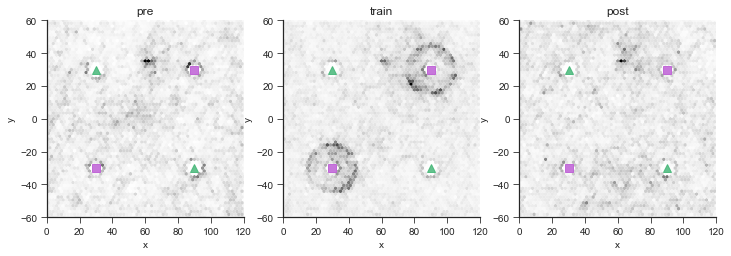

In [178]:
# plot parameter
numBins = 60

hexplotfig = plt.figure(figsize=(12,4))
for trial, condition in enumerate(trialName):
    querystring = '(trialtype == "' + condition + '") & (moving > 0)'
    xPosMA = np.asarray(FOAllFlies_df.query(querystring)['xPosInMiniarena']).squeeze()
    yPosMA = np.asarray(FOAllFlies_df.query(querystring)['yPosInMiniarena']).squeeze()
    ax = hexplotfig.add_subplot(1,len(trialName),trial+1)
    ax.hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys',linewidths=0)
    plt.xlabel('x'); plt.ylabel('y')
    
    landmarksInSquareTile(ax, LMcoords, LMcols)
            
    ax.set_title(trialName[trial])
    ax.set_xlim(0,120)
    ax.set_ylim(-60,60)
try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')
hexplotfig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_residencyMA_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### 1D radial residency close around objects

In [179]:
resdf_keylist_short = ['flyID','trial','trialtype','reinforcement','moving','time']
resdf_keylist = resdf_keylist_short + ['dist2cone','dist2cyli']
residency_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)

for trial, trialtype in enumerate(trialName):
    for fly in range(len(flyIDs)):

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        
        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)
        
        tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
        tmpdf.insert(1,'dist2cone', dist2closestCone)
        tmpdf.insert(2,'dist2cyli', dist2closestCyli)
        
        residency_df = residency_df.append(tmpdf)

residency_df = residency_df[resdf_keylist]

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in minimum
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in minimum


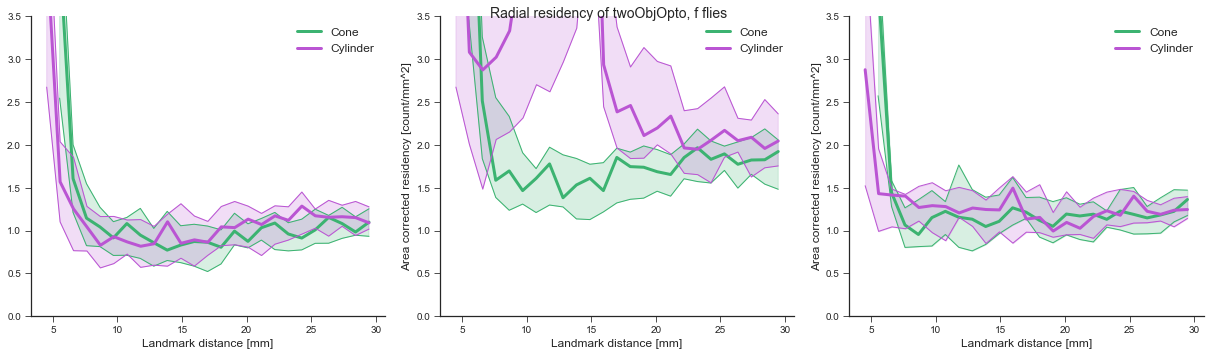

In [180]:
movementFilter = 'moving > 0'
histMax = (30,30)
histMin = (5,4) # adjust to LM base width
numBins = (25, 26)
varStyle = 'iqr' #'std', 'iqr'

# linear residency
radResFig = plt.figure(figsize=(17,5))
radResFig = oneDimResidencyWithVar_2LM_df(radResFig, residency_df, flyIDs, trialName,resdf_keylist.index('dist2cone'),
                                          resdf_keylist.index('dist2cyli'),movementFilter, numBins, histMin, histMax,
                                          1, varStyle, [coneColor,cyliColor], objtypeNames)
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResFig.tight_layout()

radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_radialResidencyVar_'+varStyle+'_lin_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Effect of reinforcement on walking velocity

Plot directory already exists


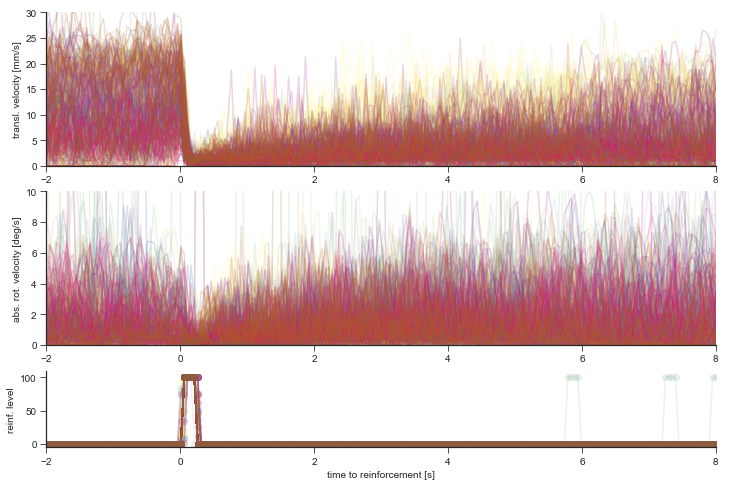

In [181]:
trialtype ='train'
 
rewardEffectFig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3,1,height_ratios=[1,1,0.5])

rewardVTPlt = rewardEffectFig.add_subplot(gs[0])
rewardVRPlt = rewardEffectFig.add_subplot(gs[1])
rewardEVPlt = rewardEffectFig.add_subplot(gs[2])
    
for fly in range(numFlies):
    flyCol = flyCMap.to_rgba(fly)
    querystring = '(trialtype=="' + trialtype + '") & (flyID =="' + flyIDs[fly] +  '")'

    perFlyX = FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1].values.squeeze()
    perFlyY = FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1].values.squeeze()
    perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].values.squeeze()
    perFlyvR = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].values.squeeze()
    perFlyEv = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

    evTimes = np.where(perFlyEv>80)[0]
    evStarts = np.where(np.diff(perFlyEv)>0)[0]

    postWindow = 160
    preWindow = 40
    timeLine = np.linspace(-preWindow*1/fps,postWindow*1/fps,preWindow+postWindow)
    for evStart in evStarts:
        evStart = evStart
        if (evStart+postWindow > len(perFlyvT) or evStart-preWindow < 0):
            continue
        rewardVTPlt.plot(timeLine,perFlyvT[evStart-preWindow:evStart+postWindow],color=flyCol,alpha=0.2)
        rewardVRPlt.plot(timeLine,abs(perFlyvR[evStart-preWindow:evStart+postWindow]),color=flyCol,alpha=0.2)
        rewardEVPlt.plot(timeLine,perFlyEv[evStart-preWindow:evStart+postWindow],'o-',color=flyCol,alpha=0.2)

rewardVTPlt.set_ylim(0,30)
rewardVTPlt.set_xlim(-preWindow*1/fps,postWindow*1/fps)
rewardVTPlt.set_ylabel('transl. velocity [mm/s]')
myAxisTheme(rewardVTPlt)

rewardVRPlt.set_ylim(0,10)
rewardVRPlt.set_xlim(-preWindow*1/fps,postWindow*1/fps)
rewardVRPlt.set_ylabel('abs. rot. velocity [deg/s]')
myAxisTheme(rewardVRPlt)

rewardEVPlt.set_ylim(-5,110)
rewardEVPlt.set_xlim(-preWindow*1/fps,postWindow*1/fps)
rewardEVPlt.set_ylabel('reinf. level')
rewardEVPlt.set_xlabel('time to reinforcement [s]')
myAxisTheme(rewardEVPlt)


try:
    mkdir(analysisDir + 'reinforcementEffect/')
except:
    print('Plot directory already exists')
rewardEffectFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                   +'_velocityRespToReinf_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf')

## Visit-based analysis

#### Plot individual traces

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in minimum


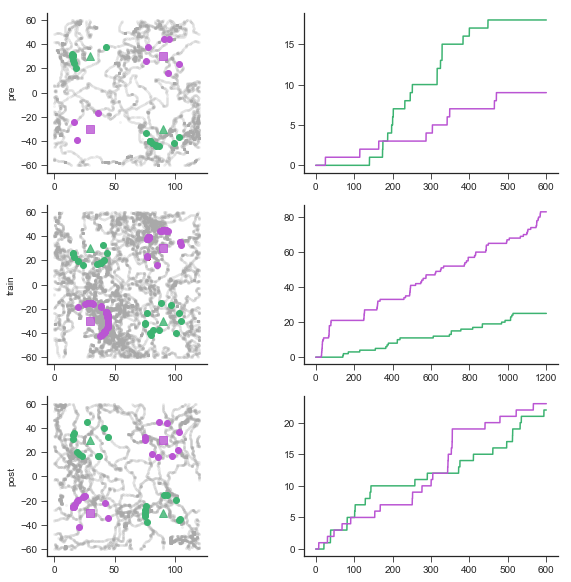

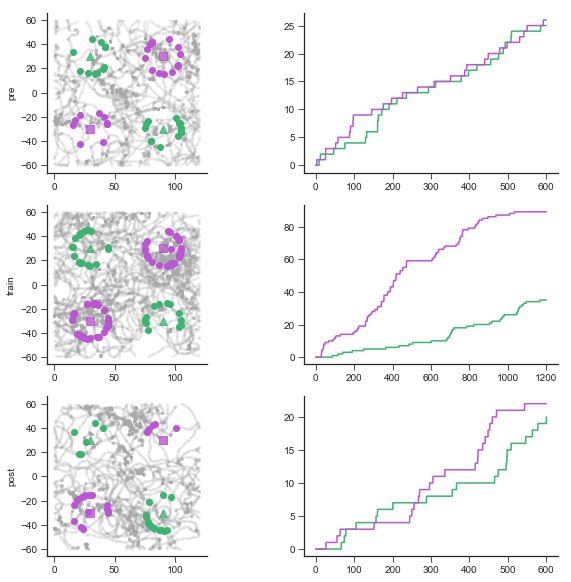

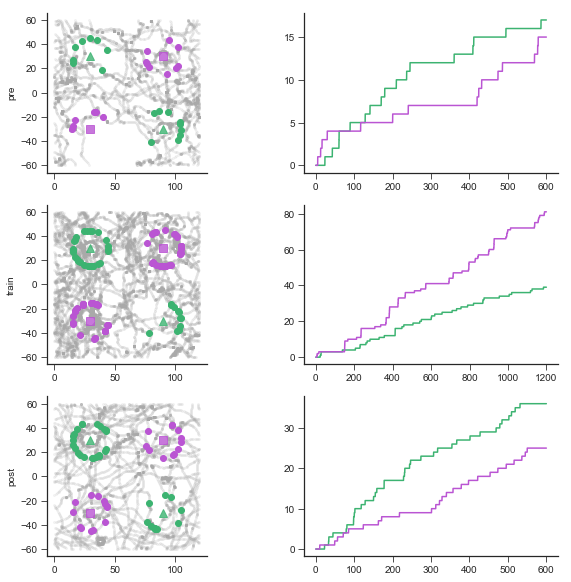

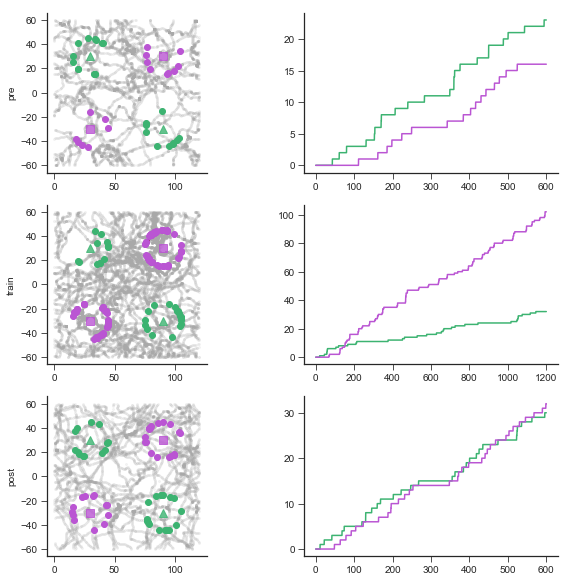

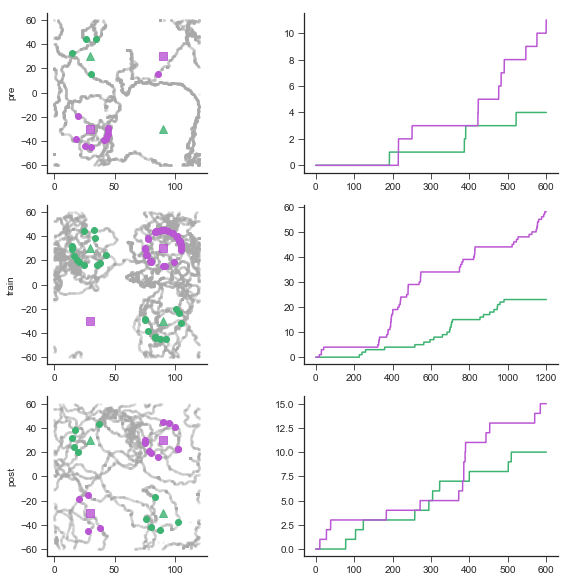

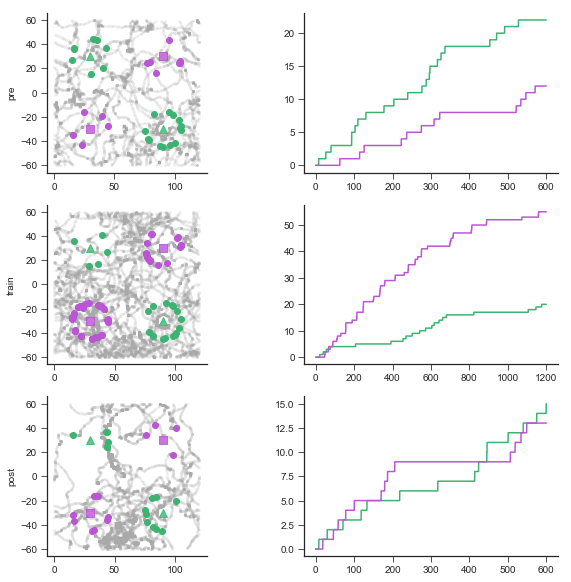

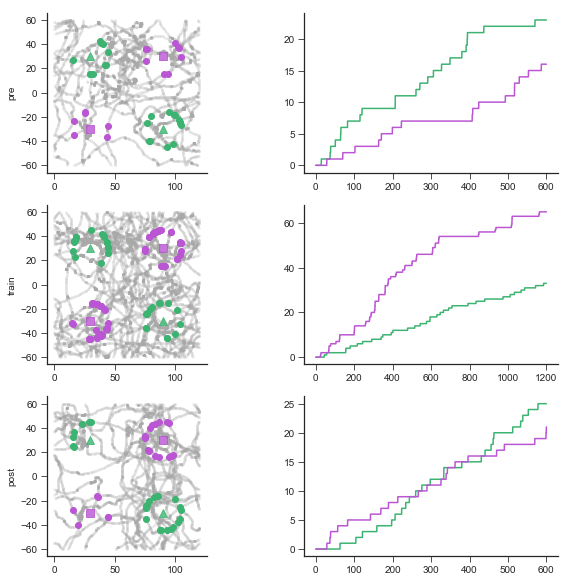

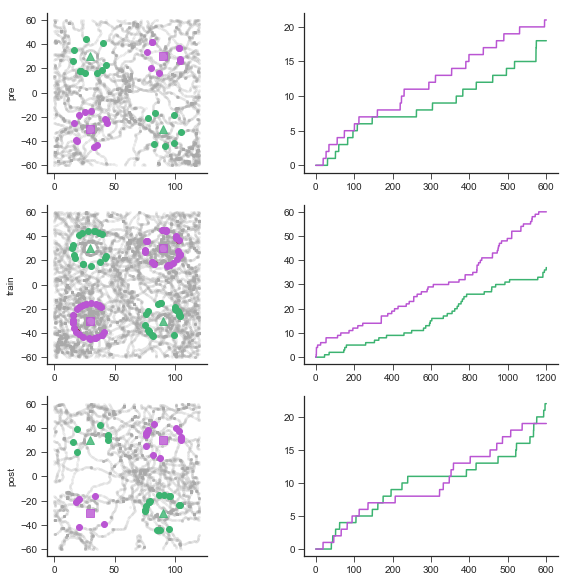

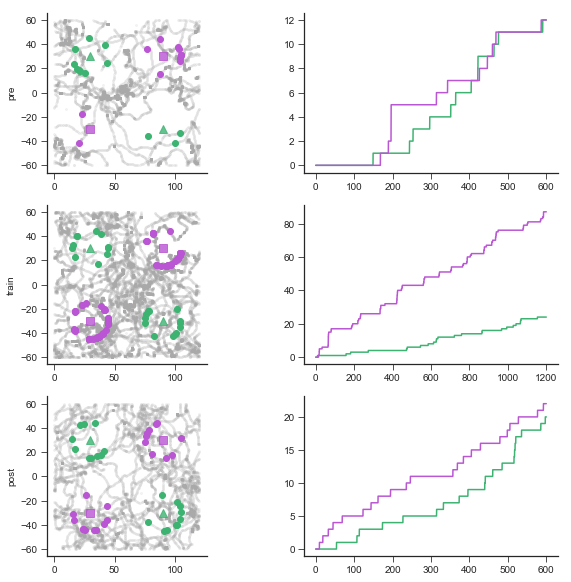

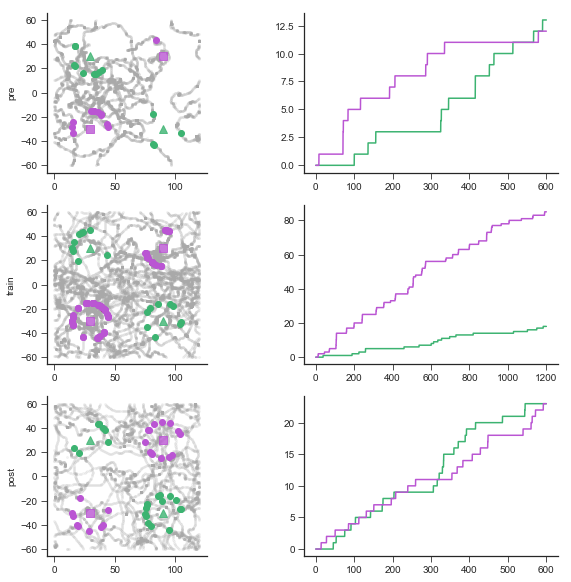

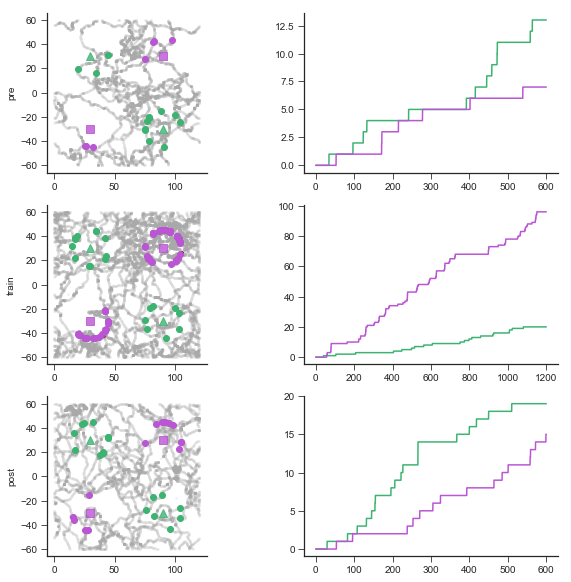

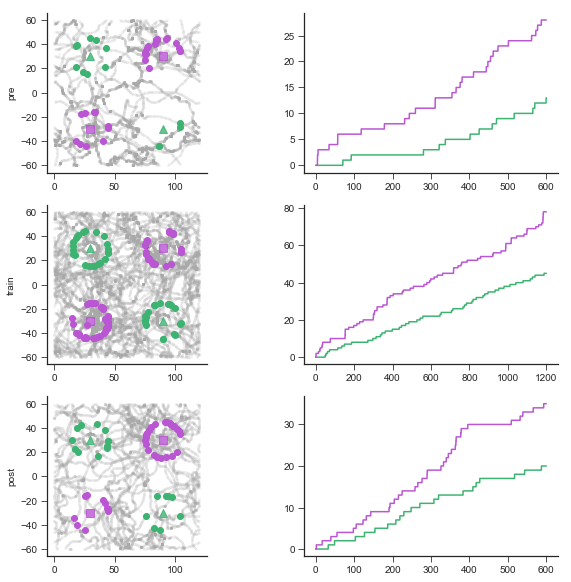

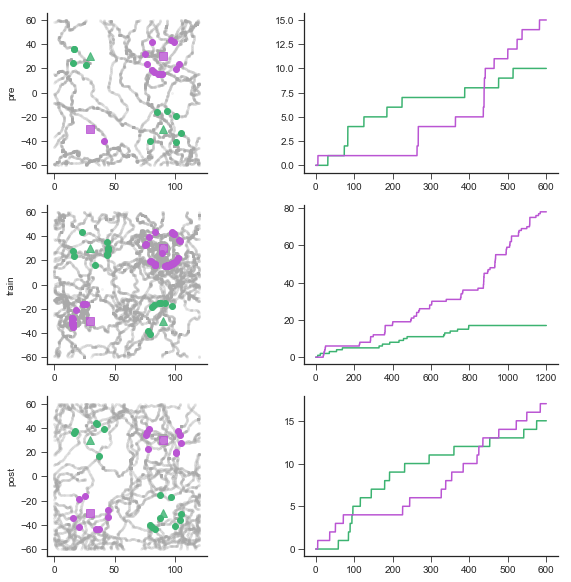

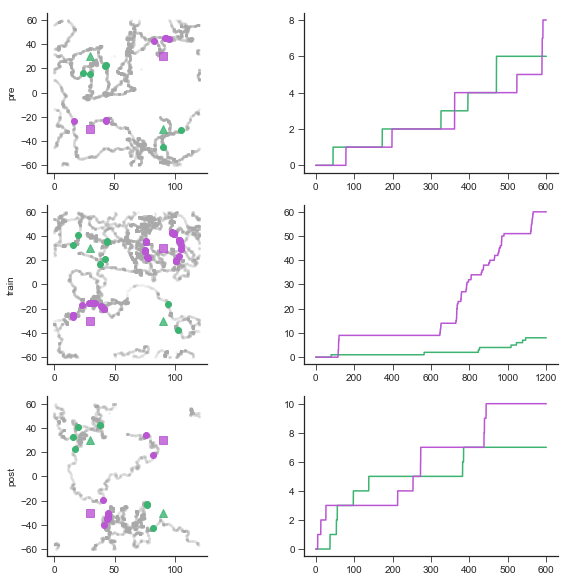

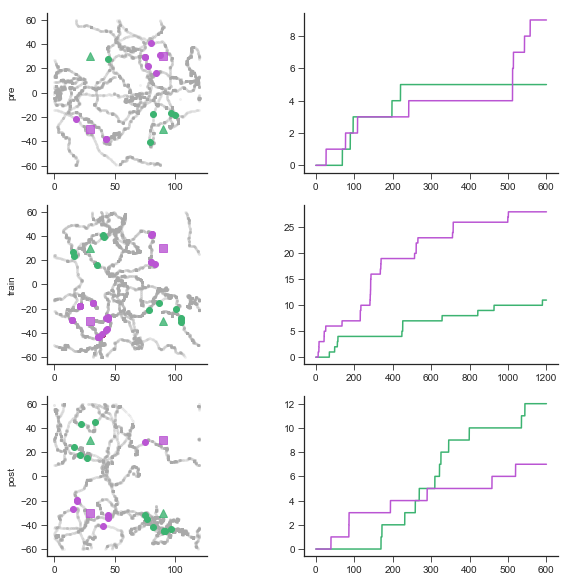

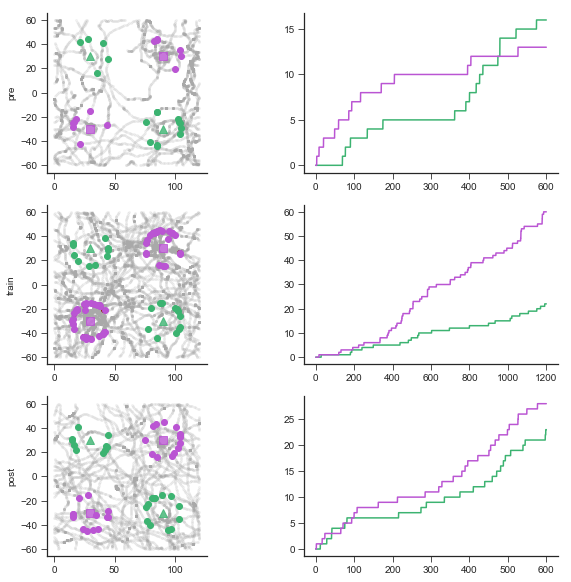

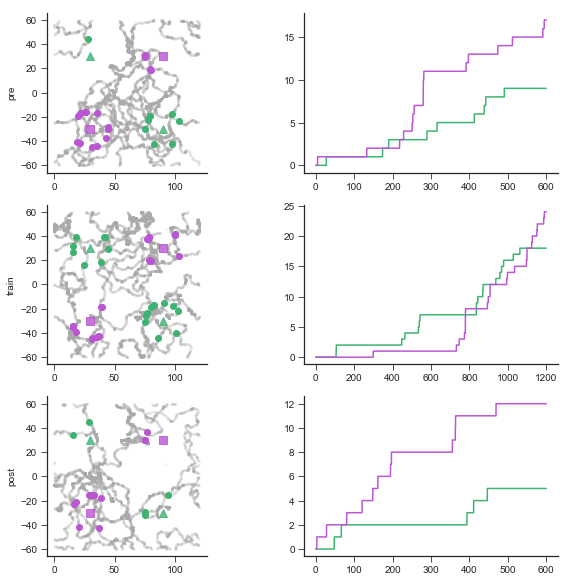

In [182]:
if exists(analysisDir + 'reinforcementEffect/'):
    if not exists(analysisDir + 'reinforcementEffect/individualFlies/'):
        mkdir(analysisDir + 'reinforcementEffect/individualFlies/')
else:
    mkdir(analysisDir + 'reinforcementEffect/')
    mkdir(analysisDir + 'reinforcementEffect/individualFlies/')

for fly in range(len(flyIDs)):
    visitFig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(len(trialName),2,width_ratios=[1,1])

    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
        
        # setup figure
        visitPlt = visitFig.add_subplot(gs[trial,0])
        cumsumVisitPlt = visitFig.add_subplot(gs[trial,1])
        
        visitPlt.plot(xtrial,ytrial,'.',color='darkgrey',markersize=4,alpha=0.1)
        visitPlt.plot(xtrial[evTrial>0],ytrial[evTrial>0],'.',markersize=7,color='darkred')
        
        # compute visits to each landmark
        dist2closest = np.nan*np.ones( (numObj, len(xtrial)) )
        
        for obj in range(numObj):
            dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                           np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
            entries,exits,visitT,entryTime,exitTime = countvisits(dist2closest[obj,:],timeTrial, visitRad)
            
            visitPlt.plot(xtrial[entries>0],ytrial[entries>0],'o',color=LMcols[obj])
            
            cumsumVisitPlt.plot(timeTrial,np.cumsum(entries),color=LMcols[obj])

        landmarksInSquareTile(visitPlt, LMcoords, LMcols)
        visitPlt.set_ylabel(trialtype)
        
        myAxisTheme(cumsumVisitPlt)

    visitFig.savefig(analysisDir + 'reinforcementEffect/individualFlies/'+ genotype +'_'+flyIDs[0][0]
                    +'_effectOnVisits_visitRad'+str(visitRad)+'mm_fly'+ flyIDs[fly] +'.pdf', format='pdf')

### Shared settings for boxplots

In [183]:
# Settings for boxplots of all three trials:
objBoxColors = [['lightgreen','seagreen','mediumseagreen'],
                ['palevioletred','darkmagenta','mediumorchid']] #for spec. objects
BoxColors = ['grey','slateblue','royalblue'] # for ratio between objects

trialColors = ['darkseagreen', 'darkviolet','teal']
trialMarkers = ['d','*','o']

offsets = [1.3, 1.3, 1.3]

boxalpha = 0.5
linealpha=0.5

allTrialFigSize = (12,4)
twoTrialFigSize = (16,4)

# Settings for boxplots of pre and post trial only
objBoxColors_pp = [['lightgreen','mediumseagreen'],
                   ['palevioletred','mediumorchid']]
BoxColors_pp = ['grey','royalblue'] 
offsets_pp = [1.32, 0.68]

### Visit count

Plot directory already exists


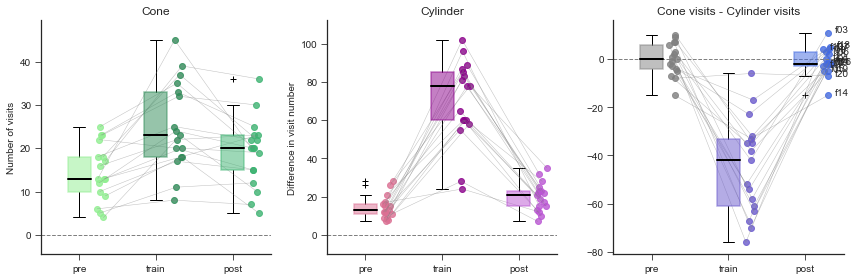

In [184]:
bpFig = plt.figure(figsize=allTrialFigSize)

VisitCount = [visitCount[0],visitCount[1]]
VisitCountRatio = visitCount[0]-visitCount[1]

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors[objtype], boxalpha, linealpha, VisitCount[objtype],
                              flyIDs, offsets, trialName, plotLabels=False)

    objBoxPlt.set_ylabel('Number of visits')
    bpPlt.set_title(objtypeNames[objtype])

bpPlt = bpFig.add_subplot(1,3,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors, boxalpha, linealpha, VisitCountRatio, flyIDs, offsets, 
                            trialName, plotLabels=True)

bpPlt.set_ylim((-5+np.min(VisitCountRatio),5+np.max(VisitCountRatio)))
objBoxPlt.set_ylabel('Difference in visit number')
bpPlt.set_title('Cone visits - Cylinder visits')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitCount_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Visit frequency [1/min]

Plot directory already exists


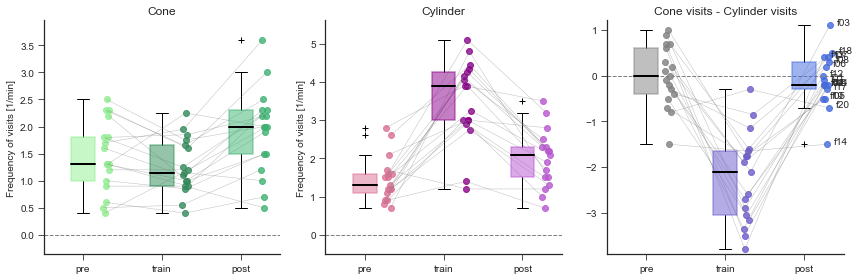

In [185]:
VisitFreq = [visitFreq[0],visitFreq[1]]
VisitFreqRatio = visitFreq[0]-visitFreq[1]

bpFig = plt.figure(figsize=allTrialFigSize)

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors[objtype], boxalpha, linealpha, VisitFreq[objtype],
                             flyIDs, offsets, trialName, plotLabels=False)

    bpPlt.set_ylabel('Frequency of visits [1/min]')
    bpPlt.set_title(objtypeNames[objtype])

bpPlt = bpFig.add_subplot(1,3,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors, boxalpha, linealpha, VisitFreqRatio,flyIDs, offsets, 
                            trialName, plotLabels=True)

bpPlt.set_ylim((-0.1*np.max(VisitFreqRatio)+np.min(VisitFreqRatio),
                0.1*np.max(VisitFreqRatio)+np.max(VisitFreqRatio)))
bpPlt.set_title('Cone visits - Cylinder visits')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitFrequency_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

p = 0.535380298068
Plot directory already exists


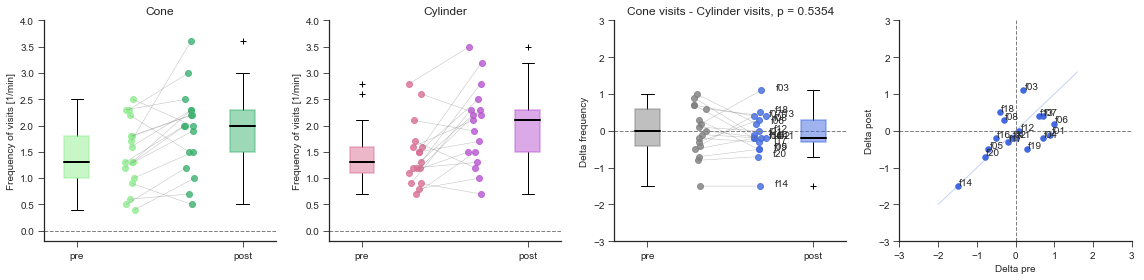

In [186]:
# compare just pre and post

VisitFreq = [visitFreq[0][:,[0,2]],visitFreq[1][:,[0,2]]]
VisitFreqRatio = visitFreq[0][:,[0,2]]-visitFreq[1][:,[0,2]]

bpFig = plt.figure(figsize=twoTrialFigSize)

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,4,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors_pp[objtype], boxalpha, linealpha, VisitFreq[objtype],
                             flyIDs, offsets_pp, trialName, plotLabels=False)
    
    bpPlt.set_xlim((0.8,2.2))
    bpPlt.set_ylim((-0.2,4))
    bpPlt.set_ylabel('Frequency of visits [1/min]')
    bpPlt.set_title(objtypeNames[objtype])

bpPlt = bpFig.add_subplot(1,4,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors_pp, boxalpha, linealpha, 
                            VisitFreqRatio, flyIDs, offsets_pp, trialName, plotLabels=True)

bpPlt.set_xlim((0.8,2.2))
bpPlt.set_ylim((-3,3))
#bpPlt.set_ylim((-0.1*np.max(VisitFreqRatio)+np.min(VisitFreqRatio),
#                0.1*np.max(VisitFreqRatio)+np.max(VisitFreqRatio)))
bpPlt.set_ylabel('Delta frequency')

from scipy import stats as sts
tval, pval = sts.ttest_rel(VisitFreqRatio[:,0], VisitFreqRatio[:,1],
              axis=0, nan_policy='propagate')
bpPlt.set_title('Cone visits - Cylinder visits, p = ' + str(round(pval,4)))
print('p = ' + str(pval))

# correlation between pre and post prefererence 
bpPlt = bpFig.add_subplot(1,4,4)

bpPlt = diffCorrPlot(bpPlt, VisitFreqRatio, flyIDs, BoxColors_pp[-1])
bpPlt.set_xlim((-3,3))
bpPlt.set_ylim((-3,3))
bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
    
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitFrequency_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
              +selectionTag+'.pdf', format='pdf')

np.savetxt(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
           +'_visitFrequency_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag+'.csv', VisitFreqRatio,delimiter=',')

In [187]:
# Compute counts for matching time periods in pre and post  (relevant for expts with extended post trial)
visitCount_10minpost = np.nan*np.ones((numObj, numFlies))

maxT = int(fps*60*10)

for fly in range(len(flyIDs)):
    querystring = '(trialtype=="' + trialName[2] + '") & (flyID == "'+flyIDs[fly]+'")'
    
    xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

    # compute distance to closest landmark for each type
    dist2closest = np.nan*np.ones( (numObj, len(xtrial)) )
        
    for obj in range(numObj):
        dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                          np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
            
        entries,exits,visitT,entryTime,exitTime = countvisits(dist2closest[obj,:],time,visitRad)
        
        visitCount_10minpost[obj, fly] = np.sum(entries)

coneTCount = np.stack((visitCount[0,:,0],visitCount_10minpost[0,:]), axis=1)
cyliTCount = np.stack((visitCount[1,:,0],visitCount_10minpost[1,:]), axis=1)

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in minimum


The angular mean is 50.0721328725 degrees.


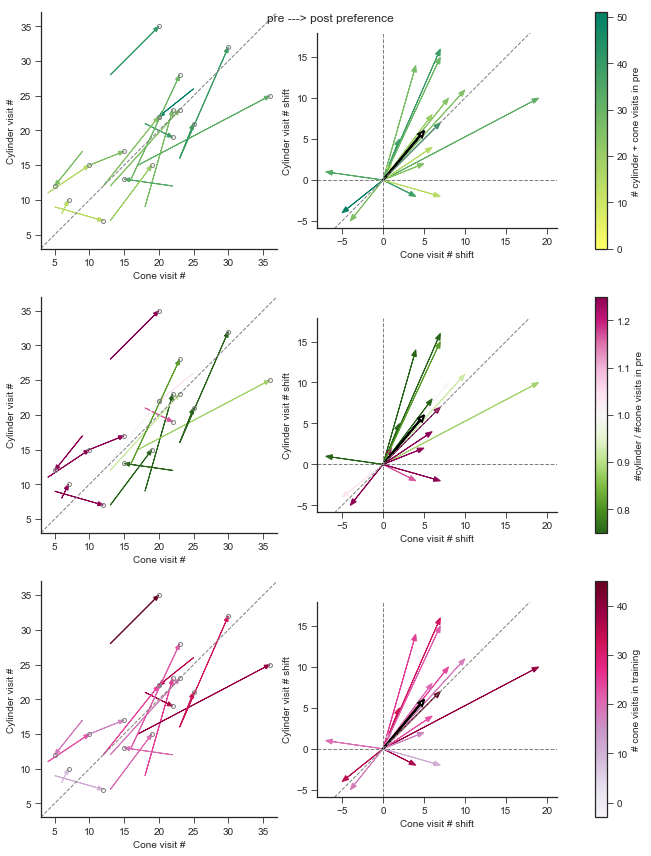

In [188]:
# Plot.........

shiftFig, axs = plt.subplots(3,3,figsize=(9,12), gridspec_kw={'width_ratios':[3,3,0.15]})

headw=0.6
headl=0.8

import matplotlib.colorbar as mplcb

for cm in range(3):
    #scatter plot of cone-change vs. cylinder-chance visits per trial
    
    if cm == 0:
        #pre vist count cmap: cylinder + cone visits in pre
        cNorm  = colors.Normalize(vmin=0, vmax=np.nanmax(visitCount[1][:,0]+visitCount[0][:,0]))
        preVisitCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='summer_r')

        cb = mplcb.ColorbarBase(axs[cm,2], cmap='summer_r', norm=cNorm, orientation='vertical')
        cblab = '# cylinder + cone visits in pre'

    elif cm == 1:
        #pre vist preference cmap: cylinder / cone visits in pre
        ratio = visitCount[1][:,0]/visitCount[0][:,0]
        lim = np.max([abs(np.min(ratio[np.isfinite(ratio)])), np.max(ratio[np.isfinite(ratio)])])
        cNorm  = colors.Normalize(vmin=-lim+4, vmax=lim-2)
        prePrefCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='PiYG_r')

        cb = mplcb.ColorbarBase(axs[cm,2], cmap='PiYG_r', norm=cNorm, orientation='vertical')
        cblab = '#cylinder / #cone visits in pre'
    
    elif cm == 2:
        #reinforcement cmap: cone visits in training
        cNorm  = colors.Normalize(vmin=-3, vmax=np.nanmax(visitCount[0][:,1]))
        reinfCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='PuRd')

        cb = mplcb.ColorbarBase(axs[cm,2], cmap='PuRd', norm=cNorm, orientation='vertical')
        cblab = '# cone visits in training'
        
    avShift = [0,0]
    for fly in range(numFlies):
        if cm==0:
            currcol = preVisitCMap.to_rgba(visitCount[1][fly,0]+visitCount[0][fly,0]) # pre visit count
            ecol = currcol
        elif cm==1:
            currcol = prePrefCMap.to_rgba(ratio[fly]) # pre visit preference
            ecol = currcol#'grey'
        elif cm==2:
            currcol = reinfCMap.to_rgba(visitCount[0][fly,1]) #training cone visits
            ecol = currcol

        flyCo = coneTCount[fly,:]
        flyCy = cyliTCount[fly,:]
        axs[cm, 0].plot(flyCo[1], flyCy[1],markersize=8, marker='.', markerfacecolor='none', markeredgecolor='gray', alpha=1)
        
        if (flyCo[0] == flyCo[1] and flyCy[0] == flyCy[1]):
            headlinc = False
        else:
            headlinc = True

        axs[cm, 0].arrow(flyCo[0], flyCy[0], flyCo[1]-flyCo[0], flyCy[1]-flyCy[0], head_width=headw,
                     head_length=headl, fc=currcol, ec=ecol, length_includes_head = headlinc)

        if (flyCo[1]-flyCo[0] + flyCo[1]-flyCo[0]): headlinc = True
        else: headlinc = False
        
        axs[cm,1].arrow(0,0, flyCo[1]-flyCo[0], flyCy[1]-flyCy[0], head_width=headw, head_length=headl,
                     fc=currcol, ec=ecol, length_includes_head = headlinc)

        avShift[0] = avShift[0]+ flyCo[1]-flyCo[0]
        avShift[1] = avShift[1]+ flyCy[1]-flyCy[0]
        
    maxplt = 1 + np.nanmax((coneTCount, cyliTCount))
    minplt = -1 + np.nanmin((coneTCount, cyliTCount))
    axs[cm,0].set_xlim(minplt, maxplt); axs[cm,0].set_ylim(minplt, maxplt)
    axs[cm,0].plot([minplt,maxplt],[minplt,maxplt],linewidth=1,color='grey',linestyle='dashed')
    axs[cm,0].set_xlabel('Cone visit #');
    axs[cm,0].set_ylabel('Cylinder visit #')

    minplt = [-0.3 + np.nanmin((coneTCount[:,1]-coneTCount[:,0])),-0.3 + np.nanmin((cyliTCount[:,1]-cyliTCount[:,0]))]
    maxplt = [0.3 + np.nanmax((coneTCount[:,1]-coneTCount[:,0])),0.3 + np.nanmax((cyliTCount[:,1]-cyliTCount[:,0]))]

    axs[cm,1].arrow(0,0, float(avShift[0]/numFlies), float(avShift[1]/numFlies), head_width=headw, head_length=headl, 
                 fc='none', ec='k', length_includes_head = False, linewidth=2)
    axs[cm,1].plot([min(minplt),max(maxplt)],[min(minplt),max(maxplt)],linewidth=1,color='grey',linestyle='dashed')
    axs[cm,1].axhline(y=0, linewidth=1, color='grey', linestyle='dashed')
    axs[cm,1].axvline(x=0, linewidth=1, color='grey', linestyle='dashed')

    axs[cm,1].set_xlim(minplt[0]*1.1, maxplt[0]*1.1)
    axs[cm,1].set_ylim(minplt[1]*1.1, maxplt[1]*1.1)
    axs[cm,1].set_xlabel('Cone visit # shift')
    axs[cm,1].set_ylabel('Cylinder visit # shift')
    
    cb.set_label(cblab)

    for i in range(2):
        myAxisTheme(axs[cm,i])
        axs[cm,i].set_aspect('equal')
        
shiftFig.suptitle('pre ---> post preference')

print('The angular mean is {} degrees.').format(180/np.pi*np.arctan((avShift[1]/numFlies)/(avShift[0]/numFlies)))

shiftFig.tight_layout()
shiftFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitFrequency_prePostFlyShift_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

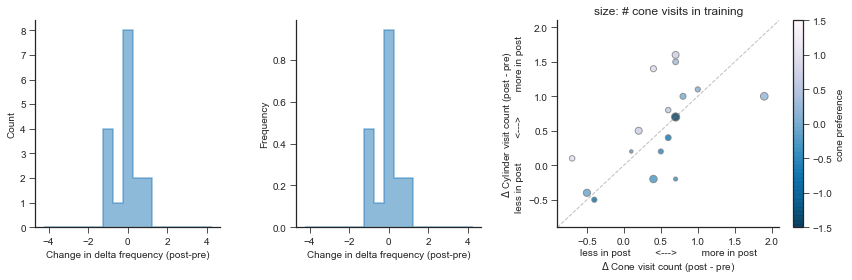

In [189]:
# Learning-induced shift in visit freuqency
histrange = (-4.25,4.25)
nbins = 17

normedvals = [False, True]
labelvals = ['Count','Frequency']

shiftFig, axs = plt.subplots(1,3,figsize=(12,4), gridspec_kw={'width_ratios':[1,1,1.5]})

for i in range(2):
    axs[i].hist(VisitFreqRatio[:,1]-VisitFreqRatio[:,0], range=histrange, bins=nbins, histtype = 'step',
                  normed=normedvals[i], fill=BoxColors_pp[-1],linewidth=1.5, align='mid', alpha=boxalpha)
    axs[i].set_xlabel('Change in delta frequency (post-pre)')
    axs[i].set_ylabel(labelvals[i])

#scatter plot of cone-change vs. cylinder-chance visits per trial
coneShift = visitFreq[0][:,2]-visitFreq[0][:,0]
cyliShift = visitFreq[1][:,2]-visitFreq[1][:,0]
cb = axs[2].scatter(coneShift, cyliShift, s=visitFreq[0][:,1]*30, c=visitFreq[0][:,0]-visitFreq[1][:,0], 
               cmap='PuBu_r',vmin=-1.5, vmax=1.5, alpha=0.8, edgecolor='grey')
plt.colorbar(cb, ax=axs[2],label='cone preference')
maxplt = 0.2 + np.nanmax((coneShift, cyliShift))
minplt = -0.2 + np.nanmin((coneShift, cyliShift))
axs[2].plot([minplt,maxplt],[minplt,maxplt],linewidth=1,color='grey',linestyle='dashed',alpha=0.5)
axs[2].set_xlabel('less in post         <--->         more in post\n$\Delta$ Cone visit count (post - pre)')
axs[2].set_ylabel('$\Delta$ Cylinder visit count (post - pre)\nless in post         <--->         more in post')
axs[2].set_xlim(minplt, maxplt)
axs[2].set_ylim(minplt, maxplt)
axs[2].set_title('size: # cone visits in training')

[myAxisTheme(axs[i]) for i in range(3)]
shiftFig.tight_layout()

shiftFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitFrequency_prePostHist_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Visit length

Plot directory already exists


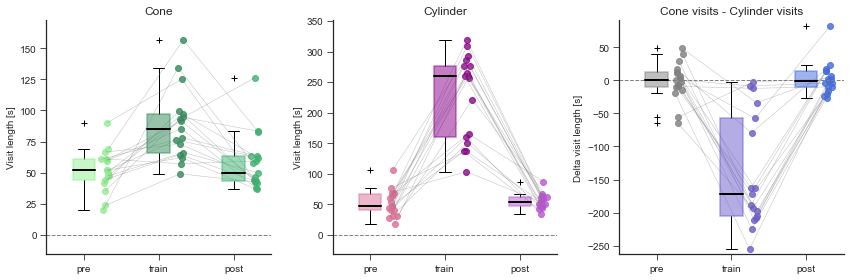

In [190]:
conelength = np.copy(visitLength[0]); cylilength = np.copy(visitLength[1])
conelength[np.isnan(conelength)] = 0; cylilength[np.isnan(cylilength)] = 0
VisitLength = [conelength,cylilength]
VisitLengthRatio = conelength-cylilength

bpFig = plt.figure(figsize=allTrialFigSize)

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors[objtype], boxalpha, linealpha, VisitLength[objtype],
                             flyIDs, offsets, trialName, plotLabels=False)

    bpPlt.set_ylabel('Visit length [s]')
    bpPlt.set_title(objtypeNames[objtype])

bpPlt = bpFig.add_subplot(1,3,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors, boxalpha, linealpha, VisitLengthRatio,flyIDs, offsets, 
                            trialName, plotLabels=False)

bpPlt.set_ylim((-0.1*np.nanmax(VisitLengthRatio)+np.nanmin(VisitLengthRatio),
                0.1*np.nanmax(VisitLengthRatio)+np.nanmax(VisitLengthRatio)))
bpPlt.set_title('Cone visits - Cylinder visits')
bpPlt.set_ylabel('Delta visit length [s]')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitLength_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
              +selectionTag+'.pdf', format='pdf')

p = 0.666784839684
Plot directory already exists


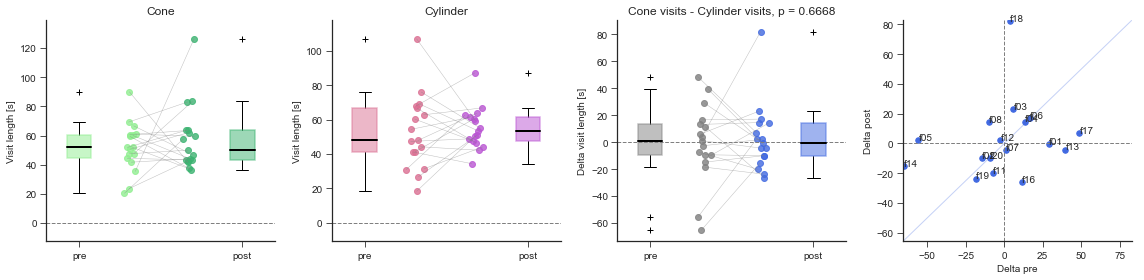

In [191]:
# compare just pre and post
conelength = np.copy(visitLength[0][:,[0,2]]); cylilength = np.copy(visitLength[1][:,[0,2]])
conelength[np.isnan(conelength)] = 0; cylilength[np.isnan(cylilength)] = 0
VisitLength = [conelength,cylilength]
VisitLengthRatio = conelength-cylilength

bpFig = plt.figure(figsize=twoTrialFigSize)

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,4,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors_pp[objtype], boxalpha, linealpha, VisitLength[objtype],
                             flyIDs, offsets_pp, trialName, plotLabels=False)
    
    bpPlt.set_xlim((0.8,2.2))
    bpPlt.set_ylabel('Visit length [s]')
    bpPlt.set_title(objtypeNames[objtype])

bpPlt = bpFig.add_subplot(1,4,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors_pp, boxalpha, linealpha,
                            VisitLengthRatio, flyIDs, offsets_pp, trialName, plotLabels=False)

bpPlt.set_xlim((0.8,2.2))
bpPlt.set_ylim((-0.1*np.nanmax(VisitLengthRatio)+np.nanmin(VisitLengthRatio),
                0.1*np.nanmax(VisitLengthRatio)+np.nanmax(VisitLengthRatio)))
bpPlt.set_ylabel('Delta visit length [s]')

tval, pval = sts.ttest_rel(VisitLengthRatio[:,0], VisitLengthRatio[:,1],
              axis=0, nan_policy='omit')
bpPlt.set_title('Cone visits - Cylinder visits, p = ' + str(round(pval,4)))
print('p = ' + str(pval))

# correlation between pre and post prefererence 
bpPlt = bpFig.add_subplot(1,4,4)

bpPlt = diffCorrPlot(bpPlt, VisitLengthRatio, flyIDs, BoxColors_pp[-1])

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitLength_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                 +selectionTag+'.pdf', format='pdf')

np.savetxt(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
           +'_visitLength_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag+'.csv', VisitFreqRatio,delimiter=',')

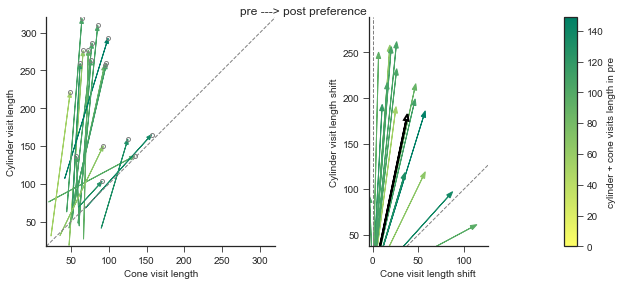

In [192]:
# Plot.........  This does not correct for cases with longer post trials

shiftFig, axs = plt.subplots(1,3,figsize=(9,4), gridspec_kw={'width_ratios':[3,3,0.15]})

headw=5#9
headl=7#12

import matplotlib.colorbar as mplcb

#pre vist count cmap: cylinder + cone visits in pre
cNorm  = colors.Normalize(vmin=0, vmax=np.nanmax(visitLength[0][:,0]+visitLength[1][:,0]))
preVisitCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='summer_r')

cb = mplcb.ColorbarBase(axs[2], cmap='summer_r', norm=cNorm, orientation='vertical')
cblab = 'cylinder + cone visits length in pre'

avShift = [0,0]
for fly in range(numFlies):
    currcol = preVisitCMap.to_rgba(visitLength[1][fly,0]+visitLength[0][fly,0]) # pre visit count
    ecol = currcol

    flyCo = visitLength[0][fly,:]
    flyCy = visitLength[1][fly,:]
    axs[0].plot(flyCo[1], flyCy[1],markersize=8, marker='.', markerfacecolor='none', markeredgecolor='gray', alpha=1)

    if (flyCo[0] == flyCo[1] and flyCy[0] == flyCy[1]):
        headlinc = False
    else:
        headlinc = True

    axs[0].arrow(flyCo[0], flyCy[0], flyCo[1]-flyCo[0], flyCy[1]-flyCy[0], head_width=headw,
                 head_length=headl, fc=currcol, ec=ecol, length_includes_head = headlinc)

    axs[1].arrow(0,0, flyCo[1]-flyCo[0], flyCy[1]-flyCy[0], head_width=headw, head_length=headl,
                 fc=currcol, ec=ecol, length_includes_head = headlinc)

    if (not np.isnan(flyCo[1]-flyCo[0])) and (not np.isnan(flyCy[1]-flyCy[0])):
        avShift[0] = avShift[0]+ flyCo[1]-flyCo[0]
        avShift[1] = avShift[1]+ flyCy[1]-flyCy[0]
        
maxplt = 1 + np.nanmax((visitLength[0], visitLength[1]))
minplt = -1 + np.nanmin((visitLength[0], visitLength[1]))
axs[0].set_xlim(minplt, maxplt); axs[0].set_ylim(minplt, maxplt)
axs[0].plot([minplt,maxplt],[minplt,maxplt],linewidth=1,color='grey',linestyle='dashed')
axs[0].set_xlabel('Cone visit length');
axs[0].set_ylabel('Cylinder visit length')

minplt = [-0.3 + np.nanmin((visitLength[0][:,1]-visitLength[0][:,0])),-0.3 + np.nanmin((visitLength[1][:,1]-visitLength[1][:,0]))]
maxplt = [0.3 + np.nanmax((visitLength[0][:,1]-visitLength[0][:,0])),0.3 + np.nanmax((visitLength[1][:,1]-visitLength[1][:,0]))]

axs[1].arrow(0,0, float(avShift[0]/numFlies), float(avShift[1]/numFlies), head_width=headw, head_length=headl, 
             fc='none', ec='k', length_includes_head = False, linewidth=2)
axs[1].plot([min(minplt),max(maxplt)],[min(minplt),max(maxplt)],linewidth=1,color='grey',linestyle='dashed')
axs[1].axhline(y=0, linewidth=1, color='grey', linestyle='dashed')
axs[1].axvline(x=0, linewidth=1, color='grey', linestyle='dashed')

axs[1].set_xlim(minplt[0]*1.1, maxplt[0]*1.1)
axs[1].set_ylim(minplt[1]*1.1, maxplt[1]*1.1)
axs[1].set_xlabel('Cone visit length shift')
axs[1].set_ylabel('Cylinder visit length shift')
    
cb.set_label(cblab)

for i in range(2):
    myAxisTheme(axs[i])
    axs[i].set_aspect('equal')
        
shiftFig.suptitle('pre ---> post preference')

shiftFig.tight_layout()
shiftFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitLength_prePostFlyShift_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Generate boxplot of visits over 5 min blocks

In [193]:
#Adjust to trial length
blockL = 5
trial5min = [int(10/blockL),int(20/blockL),int(10/blockL)]

BoxColors_5min = [[BoxColors[i]]*trial5min[i] for i in range(3)]
blockNames_5min = [[trialName[i]+' '+ str(t+1) for t in range(trial5min[i])]  for i in range(3)]
objBoxColors_5min_1 = [[objBoxColors[0][i]]*trial5min[i] for i in range(3)]
objBoxColors_5min_2 = [[objBoxColors[1][i]]*trial5min[i] for i in range(3)]
BoxColors_5min = [item for sublist in BoxColors_5min for item in sublist]
blockNames_5min = [item for sublist in blockNames_5min for item in sublist]
objBoxColors_5min = [[item for sublist in objBoxColors_5min_1 for item in sublist],
                    [item for sublist in objBoxColors_5min_2 for item in sublist]]

In [194]:
# Generate landmark visit count over 5 min blocks
visitCount_5min = np.zeros((numObj, numFlies, sum(trial5min)))
visitLength_5min = np.zeros((numObj, numFlies, sum(trial5min)))

for fly in range(numFlies):
    blockcount = 0
    
    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

        for block in range(trial5min[trial]):
            entriesCone,_,visitTCone,_,_ = countvisits(dist2closestCone[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)],
                                                       timeTrial[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)],
                                                       visitRad)
            entriesCyli,_,visitTCyli,_,_ = countvisits(dist2closestCyli[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)],
                                                    timeTrial[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)],
                                                       visitRad)

            visitCount_5min[0, fly, block+blockcount] = np.sum(entriesCone)
            visitCount_5min[1, fly, block+blockcount] = np.sum(entriesCyli)

            visitLength_5min[0, fly, block+blockcount] = np.sum(visitTCone)
            visitLength_5min[1, fly, block+blockcount] = np.sum(visitTCyli)
            
        blockcount = blockcount + trial5min[trial]

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in minimum
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in minimum


Plot directory already exists


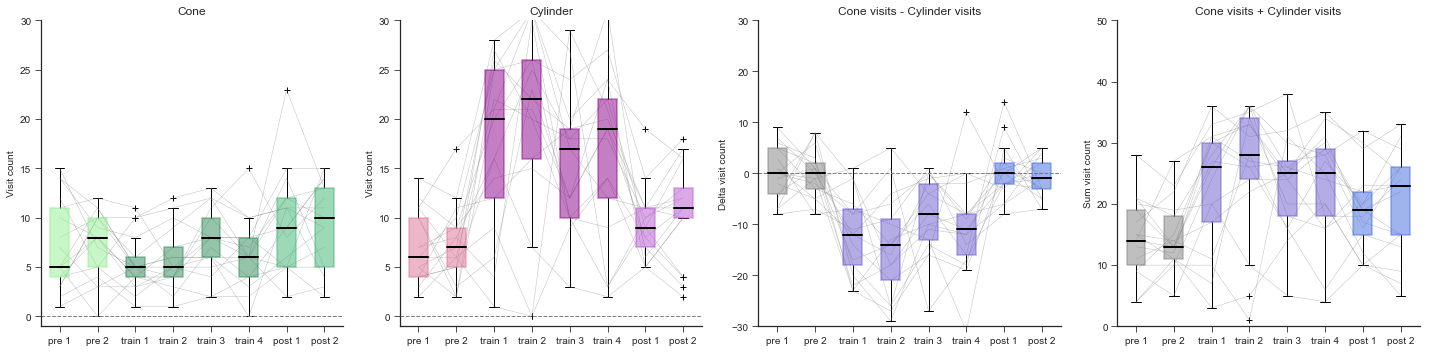

In [195]:
visitCountRatio_5min = visitCount_5min[0,:,:] - visitCount_5min[1,:,:]

bpFig, axs = plt.subplots(1,4,figsize=(20,5))

for objtype in range(numObj):    
    objBoxPlt = simpleBoxPlot(axs[objtype], objBoxColors_5min[objtype], boxalpha, linealpha, 
                              visitCount_5min[objtype,:,:], flyIDs, blockNames_5min)

    axs[objtype].set_ylabel('Visit count')
    axs[objtype].set_title(objtypeNames[objtype])
    axs[objtype].set_ylim(-1,30)

ratioBoxPlt = simpleBoxPlot(axs[2], BoxColors_5min, boxalpha, linealpha, visitCountRatio_5min, flyIDs,
                            blockNames_5min)

axs[2].set_ylim(-30,30)#((np.min(visitCountRatio_5min)-1,np.max(visitCountRatio_5min)+1))
axs[2].set_title('Cone visits - Cylinder visits')
axs[2].set_ylabel('Delta visit count')


ratioBoxPlt = simpleBoxPlot(axs[3], BoxColors_5min, boxalpha, linealpha, visitCount_5min[0]+visitCount_5min[1], flyIDs,
                            blockNames_5min)
axs[3].set_ylim(0,50)#np.max(visitCount_5min)+10)
axs[3].set_title('Cone visits + Cylinder visits')
axs[3].set_ylabel('Sum visit count')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitCount5min_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

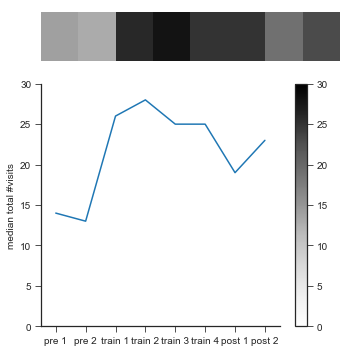

In [196]:
# Visualisation of median total visit count as heatmap
x = range(len(blockNames_5min))
y = np.median(visitCount_5min[0]+visitCount_5min[1],axis=0)

fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(5,5), gridspec_kw={'height_ratios':{1,5}})

extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
cb = ax.imshow(y[np.newaxis,:], cmap="Greys", aspect="auto", extent=extent,vmin=0, vmax=30)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])
ax.axis('off')
ax2.plot(x,y)
ax2.set_ylim(0,30)
plt.sca(ax2)
plt.xticks(x,blockNames_5min)
ax2.set_ylabel('median total #visits')
myAxisTheme(ax2)
plt.colorbar(cb, ax=ax2)

plt.tight_layout()
fig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitCount5minHeatMap_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

Plot directory already exists


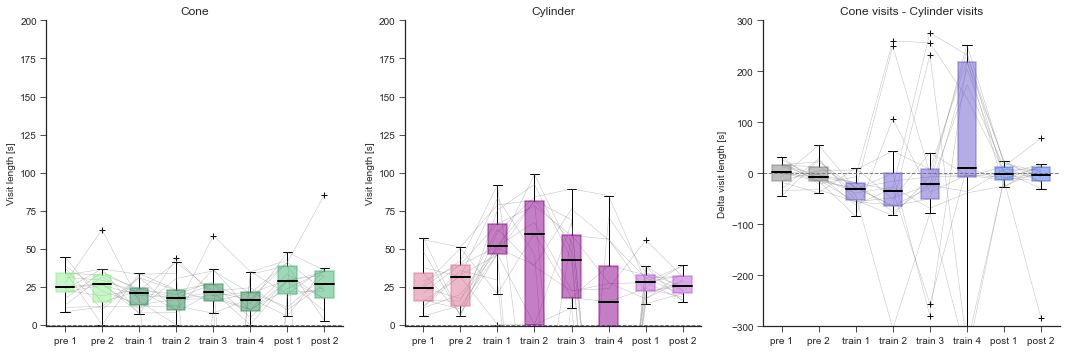

In [197]:
visitLength_5min_nan = visitLength_5min.copy()
visitLength_5min_nan[np.isnan(visitLength_5min_nan)] = 0

visitLengthRatio_5min = visitLength_5min_nan[0,:,:] - visitLength_5min_nan[1,:,:]

bpFig, axs = plt.subplots(1,3,figsize=(15,5))

for objtype in range(len(objtypeNames)):    
    objBoxPlt = simpleBoxPlot(axs[objtype], objBoxColors_5min[objtype], boxalpha, linealpha, 
                              visitLength_5min_nan[objtype,:,:], flyIDs, blockNames_5min)

    axs[objtype].set_ylabel('Visit length [s]')
    axs[objtype].set_title(objtypeNames[objtype])
    axs[objtype].set_ylim(-1,200)

ratioBoxPlt = simpleBoxPlot(axs[2], BoxColors_5min, boxalpha, linealpha, visitLengthRatio_5min, flyIDs,
                            blockNames_5min)

axs[2].set_ylim((-300, 300))
axs[2].set_title('Cone visits - Cylinder visits')
axs[2].set_ylabel('Delta visit length [s]')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitLength5min_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Cumsum visit plot

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in minimum


Plot directory already exists


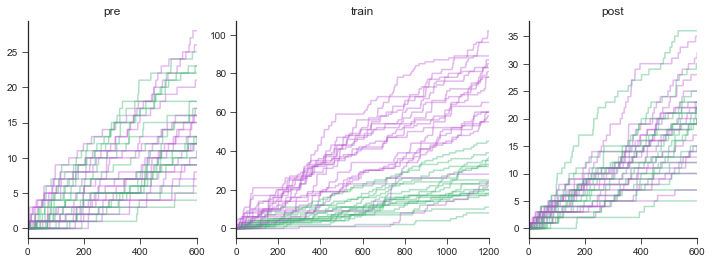

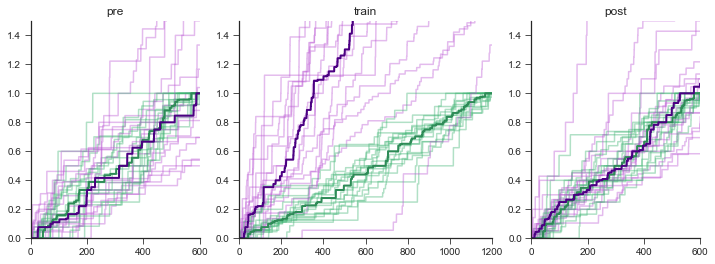

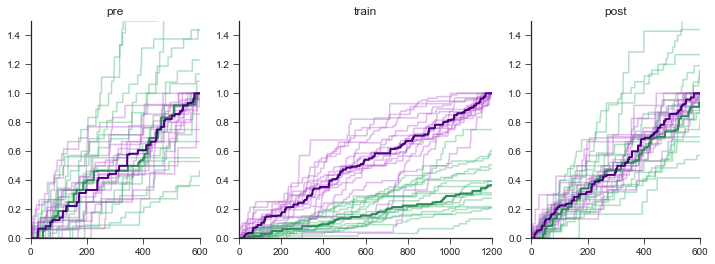

In [198]:
avLineCol = ['seagreen','indigo']

visitFig, cumsumVisitPlts = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[1, 1.5, 1]})
scaledVisitFig, scaledCumsumVisitPlts  = plt.subplots(1,len(trialName), figsize=(12,4),gridspec_kw = {'width_ratios':[1, 1.5, 1]})
revScaledVisitFig, revScaledCumsumVisitPlts  = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[1, 1.5, 1]})

alphaVal = 0.4

for trial in range(len(trialName)):
    trialtype = trialName[trial]
    
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[0]+'")'
    timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
    scaledVisits = np.nan*np.ones((numObj, numFlies, len(timeTrial)))
    revScaledVisits = np.nan*np.ones((numObj, numFlies, len(timeTrial)))
    
    for fly in range(numFlies):
        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        
        # compute distance to closest landmark for each type
        dist2closest = np.nan*np.ones( (numObj, len(xPosTrial)) )
        
        LMentries = np.zeros((numObj,len(timeTrial)))
        
        for obj in range(numObj):
            dist2closest[obj,:] = np.minimum( np.hypot((xPosTrial-LMcoords[obj][0][0]),(yPosTrial-LMcoords[obj][0][1])),
                                           np.hypot((xPosTrial-LMcoords[obj][1][0]),(yPosTrial-LMcoords[obj][1][1])) )
            
            entries,exits,visitT,entryTime,exitTime = countvisits(dist2closest[obj,:],timeTrial, visitRad)
            LMentries[obj,:] = entries
        
        
        for obj in range(numObj):
            #plot results
            cumsumVisitPlts[trial].plot(timeTrial,np.cumsum(LMentries[obj,:]),color=LMcols[obj], alpha=alphaVal)
            scaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(LMentries[obj,:])/sum(LMentries[0,:]),color=LMcols[obj], alpha=alphaVal)
            revScaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(LMentries[obj,:])/sum(LMentries[1,:]),color=LMcols[obj], alpha=alphaVal)

            scaledVisits[obj, fly,:] = np.cumsum(LMentries[obj,:])/sum(LMentries[0,:])
            revScaledVisits[obj, fly,:] = np.cumsum(LMentries[obj,:])/sum(LMentries[1,:])

    for obj in range(numObj):
        #plot averages
        scaledCumsumVisitPlts[trial].plot(timeTrial, np.nanmedian(scaledVisits[obj,:,:].squeeze(),axis=0),
                                          color = avLineCol[obj],linewidth=2)
        revScaledCumsumVisitPlts[trial].plot(timeTrial, np.nanmedian(revScaledVisits[obj,:,:].squeeze(),axis=0),
                                          color = avLineCol[obj],linewidth=2)

    cumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(cumsumVisitPlts[trial])
    cumsumVisitPlts[trial].set_title(trialtype)
    
    scaledCumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(scaledCumsumVisitPlts[trial])
    scaledCumsumVisitPlts[trial].set_title(trialtype)
    scaledCumsumVisitPlts[trial].set_ylim(0,1.5)

    revScaledCumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(revScaledCumsumVisitPlts[trial])
    revScaledCumsumVisitPlts[trial].set_title(trialtype)
    revScaledCumsumVisitPlts[trial].set_ylim(0,1.5)    
        
try:
    mkdir(analysisDir + 'reinforcementEffect/')
except:
    print('Plot directory already exists')
visitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                 +'_cumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')
scaledVisitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_coneScaledCumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')
revScaledVisitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_cyliScaledCumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in minimum


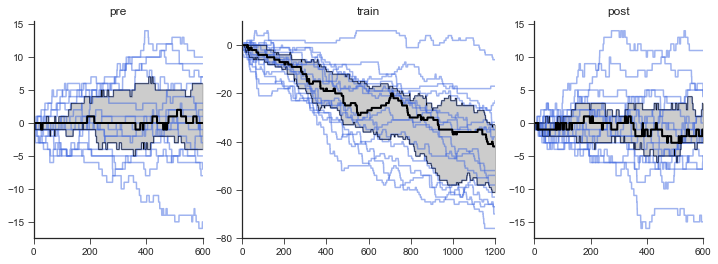

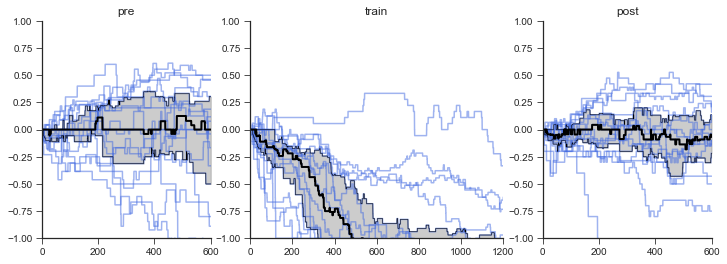

In [199]:
visitDiffFig, cumsumVisitDiffPlts = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[1, 1.5, 1]})
scaledVisitDiffFig, scaledCumsumVisitDiffPlts  = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[1, 1.5, 1]})

for trial in range(len(trialName)):
    trialtype = trialName[trial]
    
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[0]+'")'
    timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
    visitDiff = np.nan*np.ones((numFlies, len(timeTrial)))
    visitDiffNorm = np.nan*np.ones((numFlies, len(timeTrial)))
    
    for fly in range(numFlies):
        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        
        # compute distance to closest landmark for each type
        dist2closest = np.nan*np.ones( (numObj, len(xPosTrial)) )
        
        LMentries = np.zeros((numObj,len(timeTrial)))
        for obj in range(numObj):
            dist2closest[obj,:] = np.minimum( np.hypot((xPosTrial-LMcoords[obj][0][0]),(yPosTrial-LMcoords[obj][0][1])),
                                           np.hypot((xPosTrial-LMcoords[obj][1][0]),(yPosTrial-LMcoords[obj][1][1])) )
            
            entries,exits,visitT,entryTime,exitTime = countvisits(dist2closest[obj,:],timeTrial,visitRad)
            LMentries[obj,:] = entries
        
        visitDiff[fly] = np.cumsum(LMentries[0,:])-np.cumsum(LMentries[1,:])
        visitDiffNorm[fly] = np.cumsum(LMentries[0,:])/sum(LMentries[0,:]) - np.cumsum(LMentries[1,:])/sum(LMentries[0,:])
        
        cumsumVisitDiffPlts[trial].plot(timeTrial,visitDiff[fly],color=BoxColors_pp[-1], alpha=0.5)
        
        scaledCumsumVisitDiffPlts[trial].plot(timeTrial,visitDiffNorm[fly] ,color=BoxColors_pp[-1], alpha=0.5)
    
    av = np.nanmedian(visitDiff,axis=0)
    [var1,var2] = np.nanpercentile(visitDiff, [25,75], axis=0)
    cumsumVisitDiffPlts[trial].plot(timeTrial,av,color='black', alpha=1, linewidth=2)
    cumsumVisitDiffPlts[trial].plot(timeTrial,var1,color='black', alpha=1, linewidth=0.5)
    cumsumVisitDiffPlts[trial].plot(timeTrial,var2,color='black', alpha=1, linewidth=0.5)
    cumsumVisitDiffPlts[trial].fill_between(timeTrial, var1, var2, color='black', alpha=0.2)
    
    av = np.nanmedian(visitDiffNorm,axis=0)
    [var1,var2] = np.nanpercentile(visitDiffNorm,[25,75], axis=0)
    scaledCumsumVisitDiffPlts[trial].plot(timeTrial,av,color='black', alpha=1, linewidth=2)
    scaledCumsumVisitDiffPlts[trial].plot(timeTrial,var1,color='black', alpha=1, linewidth=0.5)
    scaledCumsumVisitDiffPlts[trial].plot(timeTrial,var2,color='black', alpha=1, linewidth=0.5)
    scaledCumsumVisitDiffPlts[trial].fill_between(timeTrial, var1, var2, color='black', alpha=0.2)
    
    cumsumVisitDiffPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(cumsumVisitDiffPlts[trial])
    cumsumVisitDiffPlts[trial].set_title(trialtype)
    
    scaledCumsumVisitDiffPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(scaledCumsumVisitDiffPlts[trial])
    scaledCumsumVisitDiffPlts[trial].set_title(trialtype)
    scaledCumsumVisitDiffPlts[trial].set_ylim(-1,1)
        
visitDiffFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                 +'_cumVisitDiffComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                     +selectionTag+'.pdf', format='pdf')
scaledVisitDiffFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_scaledCumVisitDiffComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                           +selectionTag+'.pdf', format='pdf')

## Effect of repeated reward on movement

### Quantify the effect of the total amount of reward a fly experienced on movement patterns


In [200]:
rewardT = np.zeros(len(flyIDs))
vTrans = np.zeros((len(flyIDs),len(trialName)))
vRot = np.zeros((len(flyIDs),len(trialName)))

for fly in range(len(flyIDs)):
    querystring = '(trialtype=="train") & (flyID == "'+flyIDs[fly]+'")'
    evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()
    rewardT[fly] = np.sum(np.sign(evTrial))/fps
    
for fly in range(len(flyIDs)):
    for trial in range(3):
        querystring = '(trialtype=="'+trialName[trial]+'") & (flyID == "'+flyIDs[fly]+'")'
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].values.squeeze()
        perFlyvR = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].values.squeeze()
        perFlymov = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].values.squeeze()

        tSt = 0#(5*len(timeTrial))/10.0
        tEnd = len(timeTrial)
        vt = perFlyvT[tSt:tEnd]
        vr = perFlyvR[tSt:tEnd]
        mov = perFlymov.astype('bool')[tSt:tEnd] 
        vTrans[fly,trial] = np.squeeze(np.nanmedian(vt[mov]))
        vRot[fly,trial] = np.squeeze(np.nanmedian(abs(vr[mov])))

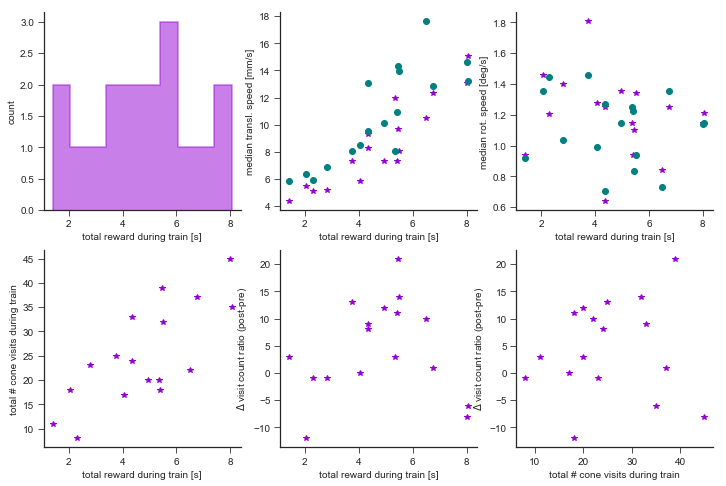

In [201]:
rewardExpFig, rewardExpAxs = plt.subplots(2,3, figsize=(12,8))

rewardExpAxs[0,0].hist(rewardT,fill=True, color=trialColors[1], alpha=boxalpha, histtype = 'step',
                      linewidth=1.5, align='mid')
rewardExpAxs[0,0].set_xlabel('total reward during train [s]')
rewardExpAxs[0,0].set_ylabel('count')

for trial in range(1,3):
    rewardExpAxs[0,1].plot(rewardT,vTrans[:,trial],marker=trialMarkers[trial],
                           linestyle='none', color=trialColors[trial])
rewardExpAxs[0,1].set_xlabel('total reward during train [s]')
rewardExpAxs[0,1].set_ylabel('median transl. speed [mm/s]')

for trial in range(1,3):
    rewardExpAxs[0,2].plot(rewardT,vRot[:,trial],marker=trialMarkers[trial],
                           linestyle='none', color=trialColors[trial])
rewardExpAxs[0,2].set_xlabel('total reward during train [s]')
rewardExpAxs[0,2].set_ylabel('median rot. speed [deg/s]')


rewardExpAxs[1,0].plot(rewardT,visitCount[0][:,1],marker=trialMarkers[1],
                      linestyle='none', color=trialColors[1])
rewardExpAxs[1,0].set_xlabel('total reward during train [s]')
rewardExpAxs[1,0].set_ylabel('total # cone visits during train')

VisitCountRatio = visitCount[0][:,2]-visitCount[1][:,0]
rewardExpAxs[1,1].plot(rewardT,VisitCountRatio,marker=trialMarkers[1],
                      linestyle='none', color=trialColors[1])
rewardExpAxs[1,1].set_xlabel('total reward during train [s]')
rewardExpAxs[1,1].set_ylabel('$\Delta$ visit count ratio (post-pre)')

rewardExpAxs[1,2].plot(visitCount[0][:,1],VisitCountRatio,marker=trialMarkers[1],
                      linestyle='none', color=trialColors[1])
rewardExpAxs[1,2].set_xlabel('total # cone visits during train')
rewardExpAxs[1,2].set_ylabel('$\Delta$ visit count ratio (post-pre)')

for i in range(2):
    
    [myAxisTheme(rewardExpAxs[i,j]) for j in range(3)]
    
rewardEffectFig.tight_layout()

rewardExpFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                 +'_totalRewardCorr_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                     + selectionTag+'.pdf', format='pdf')

### Visualization of single flies

In [250]:
resdf_keylist_short = ['flyID','trial','trialtype','reinforcement','moving','time']
resdf_keylist = resdf_keylist_short + ['dist2cone','dist2cyli','closestCone', 'closestCyli']
residency_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)

for trial, trialtype in enumerate(trialName):
    for fly in range(len(flyIDs)):

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        
        # compute distance to each landmark
        dist2cones = np.vstack(( np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1])),
                                 np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1])) ))
        dist2cylis = np.vstack(( np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1])),
                                 np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1])) ))

        # compute distance to closest landmark
        closestCone = np.argmin(dist2cones, axis=0)
        closestCyli = np.argmin(dist2cylis, axis=0)
        
        dist2closestCone = np.min(dist2cones, axis=0)
        dist2closestCyli = np.min(dist2cylis, axis=0)
        

        tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
        tmpdf.insert(1,'dist2cone', dist2closestCone)
        tmpdf.insert(2,'dist2cyli', dist2closestCyli)
        
        tmpdf.insert(3,'closestCone', closestCone)
        tmpdf.insert(4,'closestCyli', closestCyli)
        
        residency_df = residency_df.append(tmpdf)

residency_df = residency_df[resdf_keylist]

f06
Plot directory already exists


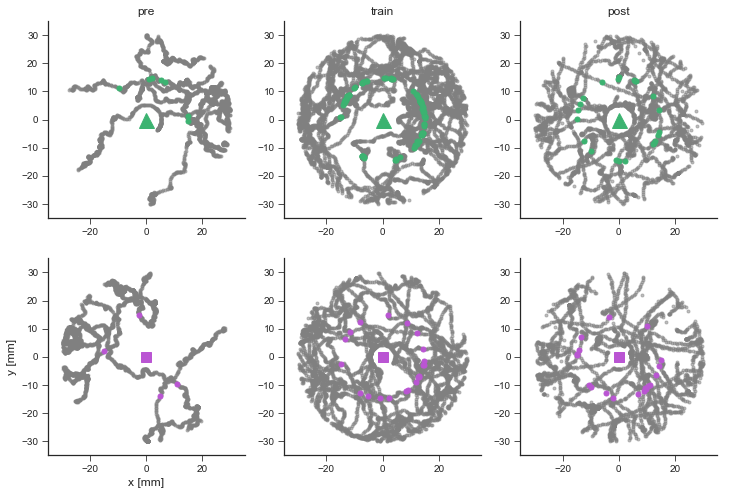

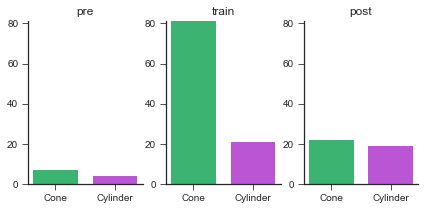

In [253]:
fly = 5

radLM = 30

print(flyIDs[fly])

movementFilter = 'moving > 0'

dLMs = ['dist2cone','dist2cyli']
cLMs = ['closestCone','closestCyli']

LMcoords = [coneCoords, cyliCoords]
LMshapes = ('^','s')
LMmsize = (15,10)

maxVisit = 0

zoomResFig, axs = plt.subplots(2,len(trialName), figsize=(12,8))
visitCountFig, axs2 = plt.subplots(1,len(trialName), figsize=(7,3))

LMvisitCount = np.zeros((len(trialName),numObj))

for trial, cond in enumerate(trialName):
    
    for LM in range(numObj):
        querystring = '(trialtype=="' + cond + '") & (flyID=="' + flyIDs[fly] + '")' #& (' + movementFilter + ')
        
        distLM = np.asarray(residency_df.query(querystring)[dLMs[LM]]).squeeze()
        distLM[np.isnan(distLM)] = 100
        entries,exits,visitT,entryTime,exitTime = countvisits(distLM[distLM<=radLM],
                                                              residency_df.query(querystring)['time'][distLM<=radLM],
                                                              visitRad)
        LMvisitCount[trial, LM] = sum(entries)
        maxVisit = max(maxVisit,sum(entries))
        
        closestLM = np.asarray(residency_df.query(querystring)[cLMs[LM]]).squeeze()[distLM<=radLM]
        
        xLM = np.asarray(FOAllFlies_df.query(querystring)['xPosInMiniarena']).squeeze()[distLM<=radLM]
        yLM = np.asarray(FOAllFlies_df.query(querystring)['yPosInMiniarena']).squeeze()[distLM<=radLM]
        
        xLM[closestLM==0] = xLM[closestLM==0]-LMcoords[LM][0][0]
        yLM[closestLM==0] = yLM[closestLM==0]-LMcoords[LM][0][1]
        xLM[closestLM==1] = xLM[closestLM==1]-LMcoords[LM][1][0]
        yLM[closestLM==1] = yLM[closestLM==1]-LMcoords[LM][1][1]
        
        axs[LM,trial].plot(xLM, yLM, '.', color='grey', alpha=0.5)
        axs[LM,trial].plot(0, 0, marker=LMshapes[LM], markersize=LMmsize[LM], alpha=1, color=LMcols[LM])
        axs[LM,trial].plot(xLM[entries>0],yLM[entries>0],'o',color=LMcols[LM],markersize=5)
        
        axs[LM,trial].set_aspect('equal')
        axs[LM,trial].set_xlim(-(radLM+5),(radLM+5))
        axs[LM,trial].set_ylim(-(radLM+5),(radLM+5))
        myAxisTheme(axs[LM,trial])

    axs[0,trial].set_title(cond)
    
    axs2[trial].bar(range(numObj), LMvisitCount[trial,:], color=LMcols, tick_label=objtypeNames, width=0.75)
    axs2[trial].set_title(cond)
    myAxisTheme(axs2[trial])

axs[1,0].set_xlabel('x [mm]', fontsize=12)
axs[1,0].set_ylabel('y [mm]', fontsize=12)

for trial in range(len(trialName)):
    axs2[trial].set_ylim(0, maxVisit)

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
zoomResFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitTrajectory_visitRad'+str(visitRad)+'mm_fly'+flyIDs[fly]+'.pdf', format='pdf')
visitCountFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitCountDemo_visitRad'+str(visitRad)+'mm_fly'+flyIDs[fly]+'.pdf', format='pdf')